# Metals

# Библиотеки

In [ ]:
# TODO

## Конфиг

In [57]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(config_path='../configs', job_name='demo', version_base='1.3'):
    cfg = compose(config_name='config')

print('Hydra Config:\n')
print(OmegaConf.to_yaml(cfg))

Hydra Config:

project:
  name: Metals
  seed: 42
  device: cuda
  wandb_entity: sasha_kovylyaev-hse
  experiment_name: default1
dataset:
  _target_: src.datasets.default.DefaultDataset
  img_paths: null
  answers_file: null
  transform: null
  augment: null
  train: null
model:
  _target_: src.models.default.DefaultModel
  weights: null
  num_classes: 3
training:
  img_dir: data/prepared_data/images
  answer_file: data/prepared_data/answer.csv
  batch_size: 32
  n_epochs: 20
  train_size: 0.7
  val_size: 0.15
  test_size: 0.15
  precision: 32
optimizer:
  _target_: torch.optim.Adam
  params: null
  lr: 0.001
criterion:
  _target_: torch.nn.CrossEntropyLoss
scheduler:
  _target_: null



# Настройки окружения

In [58]:
import random
import torch

%load_ext autoreload
%autoreload 2

SEED = cfg.project.seed
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# device = torch.device(cfg.project.device if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='mps')

## Ауги и трансформации

In [59]:
from PIL import Image
import numpy as np
import torch
import lovely_tensors as lt
lt.monkey_patch()
from src.transforms_and_augs import transform, augment

image = Image.open('/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/bi-modal_image_788.png')
im = np.asarray(image)
ten = transform(im)
ten.shape

torch.Size([3, 224, 224])

# Данные

## Посмотреть данные

In [60]:
s = 'abc'
s.replace('d', 'b')

'abc'

In [61]:
import pandas as pd

answers = pd.read_csv('/Users/aleksandr/Kursovay_METALs/Metals/data/raw_data/UHCSDB/metadata.csv', index_col=0)
str(answers.loc['micrograph4.png']['magnification'])

'nan'

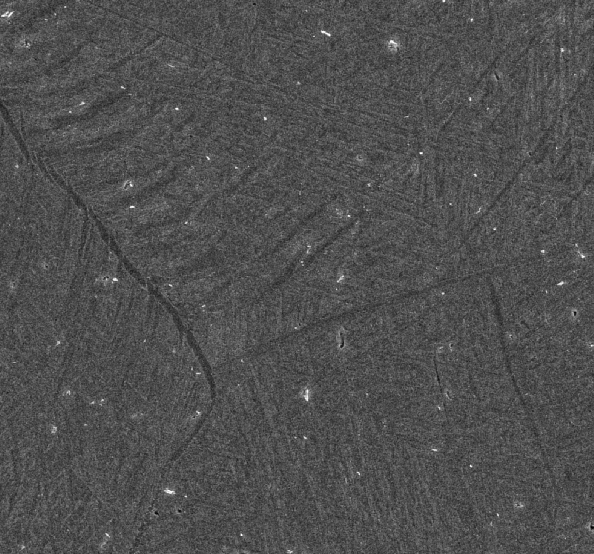

In [62]:
image = Image.open('/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/acicular_image_816.png')
image = image.convert('RGB')
image

In [63]:
import torch.nn.functional as F

image = Image.open('/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/acicular_image_816.png')
image = torch.tensor(np.asarray(image.convert('RGB'))).permute(2, 0, 1).unsqueeze(0)
print(image.shape)
x_scaled = F.interpolate(image, scale_factor=1/2, mode='bilinear', align_corners=False)
x_scaled

torch.Size([1, 3, 554, 594])


tensor[1, 3, 277, 297] u8 n=246807 (0.2Mb) x∈[22, 243] μ=80.062 σ=11.271

# Метрики

In [64]:
# Accuracy
from src.metrics import Accuracy

import torch

acc = Accuracy()

acc.update(torch.tensor([[1,0,0], [0,1,0], [0,0,1]]), torch.tensor([0,0,2]))
acc.compute()

0.6666666865348816

In [65]:
# Sqrt(MSE)

# def calc_sqrt_mse(input, target):
#     metric = MeanSquaredError(device=device)
#     metric.update(input, target)
#     return math.sqrt(metric.compute())


# calc_sqrt_mse(torch.tensor([0.9, 0.5, 0.3, 0.5]), torch.tensor([0.5, 0.8, 0.2, 0.8]))

## Параметры предобучения

In [66]:
# model = torch.hub.load("pytorch/vision", "resnet50", weights="ResNet50_Weights.IMAGENET1K_V1")

In [67]:
from hydra.utils import instantiate
from src.modules import DefaultModule
from src.datamodules import DefaultDataModule
from lightning.pytorch.loggers import WandbLogger


module = DefaultModule(cfg)
data_module = DefaultDataModule(cfg)


wandb_config = OmegaConf.to_container(
    cfg, resolve=True, throw_on_missing=True
)
wandb_logger = WandbLogger(project=cfg.project.name, name=cfg.project.experiment_name, log_model='all', dir='../checkpoints')
wandb_logger.log_hyperparams(wandb_config)


# my_list = ['fc.weight', 'fc.bias']
# my_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))))
# base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))))
# optimizer = optim.Adam([{'params': base_params}, {'params': my_params, 'lr': '1e-3'}], lr=1e-3)

Using cache found in /Users/aleksandr/.cache/torch/hub/pytorch_vision_main


Подготовка данных...
Подготовка данных завершена


/Users/aleksandr/Kursovay_METALs/Metals/.venv/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


## Загрузчики данных предобучения

In [68]:
# cutmix = v2.CutMix(num_classes=3)
# mixup = v2.MixUp(num_classes=3)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
# def collate_fn(batch):
#     return cutmix_or_mixup(*default_collate(batch))

# Предобучение

In [69]:
a = torch.tensor((1, 2))
a.p

tensor([1, 2])

In [70]:
# def train(states_path='data/states', train_metric_func=None, val_metric_func=None, metric_name='', metric_mul=1, need_to_reshape=False):
#     best_val_loss = float("inf")
#     train_losses, val_losses = [], []
#     train_metrics, val_metrics = [], []

#     val_loss, val_metric = evaluate_epoch(model, val_loader, criterion, val_metric_func, need_to_reshape)
#     print(f'Epoch: 0. Default val values:')
#     print(f'\t Val Loss: {val_loss:.3f}', end='')
#     print(f'|  Val {metric_name}: {val_metric * metric_mul:.2f}\n' if val_metric != 0 else '\n')
    
#     for epoch in range(N_EPOCHS):
        
#         start_time = time()
#         train_loss, train_metric = train_epoch(model, train_loader, optimizer, criterion, val_loader, train_metric_func, need_to_reshape)
#         val_loss, val_metric = evaluate_epoch(model, val_loader, criterion, val_metric_func, need_to_reshape)
#         end_time = time()
    
#         epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.module.state_dict(), f'{states_path}/best_model.pt')
#             torch.save(optimizer.state_dict(), f'{states_path}/best_optimizer.pt')
#         torch.save(model.module.state_dict(), f'{states_path}/last_model.pt')
#         torch.save(optimizer.state_dict(), f'{states_path}/last_optimizer.pt')
    
    
#         # clear_output()
#         print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#         print(f'\tTrain Loss: {train_loss:.3f}', end='')
#         print(f'| Train {metric_name}: {train_metric * metric_mul:.2f}\n' if train_metric != 0 else '\n')
#         print(f'\tVal Loss: {val_loss:.3f}', end='')
#         print(f'|  Val {metric_name}: {val_metric * metric_mul:.2f}\n' if val_metric != 0 else '\n')
    
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         train_metrics.append(train_metric)
#         val_metrics.append(val_metric)
    
#     fig, ax = plt.subplots(2,2, figsize=(6,8))
#     ax[0,0].plot(range(1, len(train_losses) + 1), train_losses)
#     ax[0,0].set_title(f'Train loss')
#     ax[0,1].plot(range(1, len(train_metrics) + 1), train_metrics)
#     ax[0,1].set_title(f'Train {metric_name}')
    
#     ax[1,0].plot(range(1, len(val_losses) + 1), val_losses)
#     ax[1,0].set_title(f'Val loss')
#     ax[1,1].plot(range(1, len(val_metrics) + 1), val_metrics)
#     ax[1,1].set_title(f'Val {metric_name}')


# train('data/pretrain_states', None, calc_acc, 'acc', 100)

import lightning as L


trainer = L.Trainer(
    max_epochs=cfg.training.n_epochs,
    logger=wandb_logger,
    devices=-1,
    precision=cfg.training.precision
)
trainer.fit(module, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/aleksandr/Kursovay_METALs/Metals/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./Metals/h9ijy1q8/checkpoints exists and is not empty.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)
73        Modules in train 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/aleksandr/Kursovay_METALs/Metals/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [71]:
trainer.test(ckpt_path='last', datamodule=data_module)

/Users/aleksandr/Kursovay_METALs/Metals/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:190: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9776119589805603     │
│         test_loss         │    0.08471842855215073    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc_epoch': 0.9776119589805603, 'test_loss': 0.08471842855215073}]

## Параметры дообучения

In [ ]:
batch_size = 24
val_size = 0.2


model = torch.hub.load("pytorch/vision", "resnet50", weights=None)
model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)
# model.load_state_dict(torch.load('data/pretrain_states/best_model.pt'))
model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
model = torch.nn.DataParallel(model, device_ids = [0]).to(device)



my_list = ['fc.weight', 'fc.bias']
my_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))))
base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))))

optimizer = optim.Adam([{'params': base_params}, {'params': my_params, 'lr': '1e-3'}], lr=1e-3)
# model.load_state_dict(torch.load('data/model.pt'))

criterion = nn.MSELoss()

N_EPOCHS = 100

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


## Загрузчики данных дообучения

In [ ]:
img_dir = 'data/temperature/images'
answers_path = 'data/temperature/properties.csv'

img_paths = listdir_fullpath(img_dir)

train_img_paths, val_img_paths = train_test_split(img_paths, test_size=val_size, random_state=42)

train_dataset = DefaultDataset(
    img_paths=train_img_paths,
    answers_file=answers_path,
    answer_column='Temperature, [C]',
    train=True
)
val_dataset = DefaultDataset(
    img_paths=val_img_paths,
    answers_file=answers_path,
    answer_column='Temperature, [C]',
    train=False
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4
)

# Дообучение на температуру

Val unscaled
Preds	True
[-4073.45582781] [199.99999194]
[-3203.54651351] [23.9]
[-3861.42154708] [600.0000074]
[-5163.00582228] [499.99998487]
[-3843.46210895] [350.00000706]
[-4011.45701475] [399.99999967]
[-3150.05929666] [499.99998487]
[-4755.82849512] [650.]
[-4099.43963223] [199.99999194]
[-4653.32690372] [399.99999967]

Epoch: 0. Default val values:
	 Val Loss: 52.109|  Val sqrt(mse): 7.22



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [-0.765] tensor[1] cuda:0 [0.122]
tensor[1] [-1.242] tensor[1] cuda:0 [0.920]
tensor[1] [-0.777] tensor[1] cuda:0 [0.601]
tensor[1] [-0.559] tensor[1] cuda:0 [0.601]
tensor[1] [-0.717] tensor[1] cuda:0 [0.281]
tensor[1] [-0.294] tensor[1] cuda:0 [0.201]
tensor[1] [-0.291] tensor[1] cuda:0 [1.000]
tensor[1] [-0.680] tensor[1] cuda:0 [0.920]
tensor[1] [-0.391] tensor[1] cuda:0 [0.840]
tensor[1] [-0.480] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[-455.10728013] [100.00000206]
[-754.0238433] [600.0000074]
[-462.86160998] [399.99999967]
[-326.03911912] [399.99999967]
[-425.06595063] [199.99999194]
[-160.37021745] [149.99999933]
[-157.98534343] [650.]
[-401.96738626] [600.0000074]
[-220.91013964] [550.00001479]
[-276.50661497] [499.99998487]



Val unscaled
Preds	True
[1203.93630797] [199.99999194]
[949.08013002] [23.9]
[1013.89850261] [600.0000074]
[1543.42741289] [499.99998487]
[981.87612224] [350.00000706]
[1045.21205601] [399.99999967]
[946.67831341] [499.99998487]
[1617.10750356] [650.]
[1208.77785674] [199.99999194]
[1515.49021058] [399.99999967]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.723| Train sqrt(mse): 1.31

	Val Loss: 1.871|  Val sqrt(mse): 1.37



Train: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

Train (0,1)
Preds	True
tensor[1] [-3.092] tensor[1] cuda:0 [1.000]
tensor[1] [1.840] tensor[1] cuda:0 [0.601]
tensor[1] [-2.668] tensor[1] cuda:0 [0.201]
tensor[1] [-2.815] tensor[1] cuda:0 [0.122]
tensor[1] [3.900] tensor[1] cuda:0 [0.920]
tensor[1] [-2.443] tensor[1] cuda:0 [0.760]
tensor[1] [-1.263] tensor[1] cuda:0 [0.840]
tensor[1] [9.788] tensor[1] cuda:0 [0.281]
tensor[1] [17.298] tensor[1] cuda:0 [0.920]
tensor[1] [3.902] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[-1912.1507772] [650.]
[1176.08232584] [399.99999967]
[-1646.42178893] [149.99999933]
[-1738.64124672] [100.00000206]
[2465.96845548] [600.0000074]
[-1505.68265021] [499.99998487]
[-766.99999712] [550.00001479]
[6152.14835691] [199.99999194]
[10854.39654713] [600.0000074]
[2467.2229531] [399.99999967]



Val unscaled
Preds	True
[79.56294419] [199.99999194]
[86.60744412] [23.9]
[60.59935471] [600.0000074]
[59.92016792] [499.99998487]
[64.28053237] [350.00000706]
[57.35337569] [399.99999967]
[89.55504799] [499.99998487]
[60.88019484] [650.]
[77.98136885] [199.99999194]
[57.97073978] [399.99999967]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 42.823| Train sqrt(mse): 6.54

	Val Loss: 0.344|  Val sqrt(mse): 0.59



Train: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

Train (0,1)
Preds	True
tensor[1] [2.572] tensor[1] cuda:0 [0.760]
tensor[1] [0.225] tensor[1] cuda:0 [0.601]
tensor[1] [0.750] tensor[1] cuda:0 [0.601]
tensor[1] [0.696] tensor[1] cuda:0 [0.122]
tensor[1] [2.873] tensor[1] cuda:0 [1.000]
tensor[1] [0.741] tensor[1] cuda:0 [0.920]
tensor[1] [0.198] tensor[1] cuda:0 [0.920]
tensor[1] [0.273] tensor[1] cuda:0 [0.281]
tensor[1] [2.451] tensor[1] cuda:0 [0.840]
tensor[1] [2.675] tensor[1] cuda:0 [0.201]

Train unscaled
Preds	True
[1634.28340313] [499.99998487]
[164.73723965] [399.99999967]
[493.2537388] [399.99999967]
[459.91315818] [100.00000206]
[1822.38609664] [650.]
[487.69974315] [600.0000074]
[147.7484642] [600.0000074]
[195.06048218] [199.99999194]
[1558.33524525] [550.00001479]
[1698.42354989] [149.99999933]



Val unscaled
Preds	True
[124.02358397] [199.99999194]
[125.77615253] [23.9]
[122.54177956] [600.0000074]
[129.52828193] [499.99998487]
[120.33551173] [350.00000706]
[118.20304116] [399.99999967]
[125.98097494] [499.99998487]
[111.3807214] [650.]
[119.18619621] [199.99999194]
[115.11904296] [399.99999967]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.655| Train sqrt(mse): 1.29

	Val Loss: 0.263|  Val sqrt(mse): 0.51



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.760] tensor[1] cuda:0 [0.760]
tensor[1] [0.589] tensor[1] cuda:0 [0.281]
tensor[1] [0.745] tensor[1] cuda:0 [0.201]
tensor[1] [1.083] tensor[1] cuda:0 [0.840]
tensor[1] [-0.590] tensor[1] cuda:0 [0.122]
tensor[1] [0.247] tensor[1] cuda:0 [0.601]
tensor[1] [0.294] tensor[1] cuda:0 [0.601]
tensor[1] [-1.241] tensor[1] cuda:0 [0.920]
tensor[1] [-0.039] tensor[1] cuda:0 [0.920]
tensor[1] [0.716] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[499.69173433] [499.99998487]
[392.82018763] [199.99999194]
[490.11797988] [149.99999933]
[701.90073414] [550.00001479]
[-345.37613118] [100.00000206]
[178.36910693] [399.99999967]
[208.072611] [399.99999967]
[-753.23769245] [600.0000074]
[-0.48709178] [600.0000074]
[472.39838755] [650.]



Val unscaled
Preds	True
[-148.67716587] [199.99999194]
[-169.20767852] [23.9]
[-170.04769858] [600.0000074]
[-144.68285827] [499.99998487]
[-171.20606382] [350.00000706]
[-162.6145128] [399.99999967]
[-170.5166611] [499.99998487]
[-139.95526144] [650.]
[-149.34781606] [199.99999194]
[-146.77644299] [399.99999967]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.685| Train sqrt(mse): 0.83

	Val Loss: 0.829|  Val sqrt(mse): 0.91



Train: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

Train (0,1)
Preds	True
tensor[1] [-1.329] tensor[1] cuda:0 [1.000]
tensor[1] [-1.507] tensor[1] cuda:0 [0.840]
tensor[1] [0.024] tensor[1] cuda:0 [0.601]
tensor[1] [-0.058] tensor[1] cuda:0 [0.920]
tensor[1] [-0.453] tensor[1] cuda:0 [0.601]
tensor[1] [0.783] tensor[1] cuda:0 [0.281]
tensor[1] [-1.508] tensor[1] cuda:0 [0.201]
tensor[1] [-1.118] tensor[1] cuda:0 [0.760]
tensor[1] [1.087] tensor[1] cuda:0 [0.122]
tensor[1] [0.491] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[-808.02978686] [650.]
[-919.50975386] [550.00001479]
[38.85088155] [399.99999967]
[-12.17984715] [600.0000074]
[-259.64542203] [399.99999967]
[514.12491309] [199.99999194]
[-920.08206989] [149.99999933]
[-676.25887312] [499.99998487]
[704.51481819] [100.00000206]
[331.44407054] [600.0000074]



Train: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Val unscaled
Preds	True
[-404.41480603] [199.99999194]
[-361.07145786] [23.9]
[-377.75729131] [600.0000074]
[-449.71431367] [499.99998487]
[-375.97805871] [350.00000706]
[-390.91884328] [399.99999967]
[-358.42856395] [499.99998487]
[-452.46968544] [650.]
[-412.77160523] [199.99999194]
[-449.80037006] [399.99999967]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.115| Train sqrt(mse): 1.45

	Val Loss: 1.677|  Val sqrt(mse): 1.30



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.193] tensor[1] cuda:0 [0.840]
tensor[1] [0.005] tensor[1] cuda:0 [1.000]
tensor[1] [-0.326] tensor[1] cuda:0 [0.122]
tensor[1] [-0.527] tensor[1] cuda:0 [0.281]
tensor[1] [-0.444] tensor[1] cuda:0 [0.920]
tensor[1] [-0.465] tensor[1] cuda:0 [0.601]
tensor[1] [0.045] tensor[1] cuda:0 [0.760]
tensor[1] [-0.538] tensor[1] cuda:0 [0.601]
tensor[1] [-0.262] tensor[1] cuda:0 [0.201]
tensor[1] [-0.261] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[145.01764798] [550.00001479]
[26.83235752] [650.]
[-180.10204025] [100.00000206]
[-305.84221491] [199.99999194]
[-254.1799831] [600.0000074]
[-266.97372425] [399.99999967]
[51.83409788] [499.99998487]
[-312.78285288] [399.99999967]
[-140.07637852] [149.99999933]
[-139.39882442] [600.0000074]



Val unscaled
Preds	True
[-182.76420915] [199.99999194]
[-171.62906866] [23.9]
[-156.04763795] [600.0000074]
[-281.30910996] [499.99998487]
[-160.00337691] [350.00000706]
[-167.86234774] [399.99999967]
[-172.04237069] [499.99998487]
[-299.11089623] [650.]
[-196.73741913] [199.99999194]
[-286.66634399] [399.99999967]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.868| Train sqrt(mse): 0.93

	Val Loss: 1.003|  Val sqrt(mse): 1.00



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.886] tensor[1] cuda:0 [0.840]
tensor[1] [-0.164] tensor[1] cuda:0 [0.920]
tensor[1] [0.807] tensor[1] cuda:0 [1.000]
tensor[1] [0.068] tensor[1] cuda:0 [0.601]
tensor[1] [0.028] tensor[1] cuda:0 [0.601]
tensor[1] [0.985] tensor[1] cuda:0 [0.760]
tensor[1] [0.145] tensor[1] cuda:0 [0.122]
tensor[1] [0.700] tensor[1] cuda:0 [0.201]
tensor[1] [-0.573] tensor[1] cuda:0 [0.281]
tensor[1] [-0.622] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[578.8168134] [550.00001479]
[-79.05281832] [600.0000074]
[528.89115918] [650.]
[66.7188651] [399.99999967]
[41.44796587] [399.99999967]
[640.50830887] [499.99998487]
[114.8116694] [100.00000206]
[461.88849933] [149.99999933]
[-335.1075815] [199.99999194]
[-365.61565308] [600.0000074]



Val unscaled
Preds	True
[-186.52975453] [199.99999194]
[-197.72913876] [23.9]
[-189.01997859] [600.0000074]
[-198.7129842] [499.99998487]
[-187.05141074] [350.00000706]
[-197.03173123] [399.99999967]
[-197.15266173] [499.99998487]
[-232.69193454] [650.]
[-183.90785226] [199.99999194]
[-223.76882759] [399.99999967]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.524| Train sqrt(mse): 0.72

	Val Loss: 0.958|  Val sqrt(mse): 0.98



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.005] tensor[1] cuda:0 [0.840]
tensor[1] [3.398] tensor[1] cuda:0 [0.920]
tensor[1] [-0.482] tensor[1] cuda:0 [0.201]
tensor[1] [0.546] tensor[1] cuda:0 [0.281]
tensor[1] [-0.430] tensor[1] cuda:0 [0.760]
tensor[1] [1.908] tensor[1] cuda:0 [0.122]
tensor[1] [2.721] tensor[1] cuda:0 [0.601]
tensor[1] [0.426] tensor[1] cuda:0 [0.601]
tensor[1] [0.699] tensor[1] cuda:0 [0.920]
tensor[1] [-0.472] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[27.33901695] [550.00001479]
[2151.55961542] [600.0000074]
[-278.09638171] [149.99999933]
[365.96585531] [199.99999194]
[-245.34188762] [499.99998487]
[1218.59358413] [100.00000206]
[1727.71780097] [399.99999967]
[290.84292071] [399.99999967]
[461.55841748] [600.0000074]
[-271.65631501] [650.]



Val unscaled
Preds	True
[-605.47723323] [199.99999194]
[-633.92010078] [23.9]
[-620.77429721] [600.0000074]
[-561.57171965] [499.99998487]
[-621.85810016] [350.00000706]
[-622.73866674] [399.99999967]
[-637.58275915] [499.99998487]
[-634.52540634] [650.]
[-596.01293386] [199.99999194]
[-621.11195471] [399.99999967]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 1.873| Train sqrt(mse): 1.37

	Val Loss: 2.630|  Val sqrt(mse): 1.62



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [0.234] tensor[1] cuda:0 [0.920]
tensor[1] [2.915] tensor[1] cuda:0 [0.201]
tensor[1] [-0.409] tensor[1] cuda:0 [0.601]
tensor[1] [1.700] tensor[1] cuda:0 [0.840]
tensor[1] [2.844] tensor[1] cuda:0 [0.760]
tensor[1] [3.063] tensor[1] cuda:0 [1.000]
tensor[1] [-0.680] tensor[1] cuda:0 [0.281]
tensor[1] [1.590] tensor[1] cuda:0 [0.920]
tensor[1] [-0.572] tensor[1] cuda:0 [0.122]
tensor[1] [1.861] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[170.62717615] [600.0000074]
[1848.72263522] [149.99999933]
[-231.86503192] [399.99999967]
[1087.99581375] [550.00001479]
[1804.71147306] [499.99998487]
[1941.65278592] [650.]
[-402.08329742] [199.99999194]
[1019.2416116] [600.0000074]
[-334.28351509] [100.00000206]
[1189.1870791] [399.99999967]



Val unscaled
Preds	True
[-317.96097692] [199.99999194]
[-361.45908478] [23.9]
[-285.03627331] [600.0000074]
[-231.31014362] [499.99998487]
[-289.76079137] [350.00000706]
[-284.87987161] [399.99999967]
[-382.55592385] [499.99998487]
[-321.54183321] [650.]
[-313.24291496] [199.99999194]
[-304.64738952] [399.99999967]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.163| Train sqrt(mse): 1.47

	Val Loss: 1.300|  Val sqrt(mse): 1.14



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [1.268] tensor[1] cuda:0 [0.760]
tensor[1] [1.745] tensor[1] cuda:0 [0.840]
tensor[1] [1.424] tensor[1] cuda:0 [0.201]
tensor[1] [1.664] tensor[1] cuda:0 [0.281]
tensor[1] [1.140] tensor[1] cuda:0 [1.000]
tensor[1] [1.676] tensor[1] cuda:0 [0.601]
tensor[1] [-0.805] tensor[1] cuda:0 [0.920]
tensor[1] [1.527] tensor[1] cuda:0 [0.601]
tensor[1] [1.006] tensor[1] cuda:0 [0.122]
tensor[1] [1.484] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[817.49021084] [499.99998487]
[1116.3901673] [550.00001479]
[915.65002239] [149.99999933]
[1065.78318981] [199.99999194]
[737.96186841] [650.]
[1072.99610332] [399.99999967]
[-480.42267346] [600.0000074]
[979.97571657] [399.99999967]
[653.76879209] [100.00000206]
[953.214046] [600.0000074]



Val unscaled
Preds	True
[-282.98855298] [199.99999194]
[-407.86000969] [23.9]
[-268.86784175] [600.0000074]
[-221.54067247] [499.99998487]
[-299.84890625] [350.00000706]
[-272.59004174] [399.99999967]
[-426.86574571] [499.99998487]
[-308.77753634] [650.]
[-296.71184119] [199.99999194]
[-300.97984243] [399.99999967]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.059| Train sqrt(mse): 1.03

	Val Loss: 1.298|  Val sqrt(mse): 1.14



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [-0.025] tensor[1] cuda:0 [0.840]
tensor[1] [0.037] tensor[1] cuda:0 [0.201]
tensor[1] [1.353] tensor[1] cuda:0 [0.920]
tensor[1] [3.167] tensor[1] cuda:0 [0.920]
tensor[1] [1.002] tensor[1] cuda:0 [0.601]
tensor[1] [2.067] tensor[1] cuda:0 [0.601]
tensor[1] [2.352] tensor[1] cuda:0 [0.281]
tensor[1] [-0.179] tensor[1] cuda:0 [0.760]
tensor[1] [-0.320] tensor[1] cuda:0 [1.000]
tensor[1] [0.519] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[8.36559289] [550.00001479]
[47.06960241] [149.99999933]
[870.94391571] [600.0000074]
[2006.9120389] [600.0000074]
[651.52759417] [399.99999967]
[1318.29733534] [399.99999967]
[1496.59542236] [199.99999194]
[-87.86613434] [499.99998487]
[-176.57139596] [650.]
[348.94803677] [100.00000206]



Val unscaled
Preds	True
[-649.95987692] [199.99999194]
[-783.21479686] [23.9]
[-685.92555054] [600.0000074]
[-514.07736363] [499.99998487]
[-696.22141734] [350.00000706]
[-688.85087062] [399.99999967]
[-767.34131182] [499.99998487]
[-511.27497059] [650.]
[-676.52704363] [199.99999194]
[-562.01566015] [399.99999967]

Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 1.540| Train sqrt(mse): 1.24

	Val Loss: 2.802|  Val sqrt(mse): 1.67



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.745] tensor[1] cuda:0 [0.601]
tensor[1] [0.934] tensor[1] cuda:0 [0.920]
tensor[1] [0.218] tensor[1] cuda:0 [0.201]
tensor[1] [1.195] tensor[1] cuda:0 [0.760]
tensor[1] [0.241] tensor[1] cuda:0 [0.601]
tensor[1] [0.823] tensor[1] cuda:0 [0.281]
tensor[1] [0.817] tensor[1] cuda:0 [1.000]
tensor[1] [0.945] tensor[1] cuda:0 [0.840]
tensor[1] [-0.163] tensor[1] cuda:0 [0.920]
tensor[1] [0.592] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[490.37745519] [399.99999967]
[608.88128034] [600.0000074]
[160.18300575] [149.99999933]
[771.84808235] [499.99998487]
[174.64759734] [399.99999967]
[539.10514926] [199.99999194]
[535.37046625] [650.]
[615.55218043] [550.00001479]
[-77.9731204] [600.0000074]
[394.4211126] [100.00000206]



Val unscaled
Preds	True
[-647.83138077] [199.99999194]
[-679.74225357] [23.9]
[-682.47978711] [600.0000074]
[-456.56572318] [499.99998487]
[-682.06234273] [350.00000706]
[-668.85839698] [399.99999967]
[-683.01314266] [499.99998487]
[-494.3265644] [650.]
[-670.08184564] [199.99999194]
[-478.99789167] [399.99999967]

Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.207| Train sqrt(mse): 0.46

	Val Loss: 2.607|  Val sqrt(mse): 1.61



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.462] tensor[1] cuda:0 [0.920]
tensor[1] [0.537] tensor[1] cuda:0 [1.000]
tensor[1] [-0.559] tensor[1] cuda:0 [0.601]
tensor[1] [0.904] tensor[1] cuda:0 [0.840]
tensor[1] [0.476] tensor[1] cuda:0 [0.601]
tensor[1] [0.047] tensor[1] cuda:0 [0.122]
tensor[1] [-0.380] tensor[1] cuda:0 [0.920]
tensor[1] [0.749] tensor[1] cuda:0 [0.201]
tensor[1] [-0.448] tensor[1] cuda:0 [0.281]
tensor[1] [1.224] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[313.40135624] [600.0000074]
[359.82487748] [650.]
[-325.93320931] [399.99999967]
[589.89472601] [550.00001479]
[321.65317859] [399.99999967]
[53.04674751] [100.00000206]
[-214.01781042] [600.0000074]
[492.62540776] [149.99999933]
[-256.87547739] [199.99999194]
[790.29385476] [499.99998487]



Val unscaled
Preds	True
[-227.79093744] [199.99999194]
[-125.76816998] [23.9]
[-242.33510133] [600.0000074]
[-130.72245785] [499.99998487]
[-241.90090095] [350.00000706]
[-256.43987758] [399.99999967]
[-105.16035212] [499.99998487]
[-37.67743157] [650.]
[-252.44392797] [199.99999194]
[-84.23106365] [399.99999967]

Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 0.453| Train sqrt(mse): 0.67

	Val Loss: 0.860|  Val sqrt(mse): 0.93



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [-0.773] tensor[1] cuda:0 [0.281]
tensor[1] [-0.904] tensor[1] cuda:0 [0.920]
tensor[1] [0.600] tensor[1] cuda:0 [0.760]
tensor[1] [-0.519] tensor[1] cuda:0 [0.201]
tensor[1] [0.071] tensor[1] cuda:0 [0.601]
tensor[1] [-0.440] tensor[1] cuda:0 [1.000]
tensor[1] [0.953] tensor[1] cuda:0 [0.840]
tensor[1] [0.346] tensor[1] cuda:0 [0.601]
tensor[1] [0.647] tensor[1] cuda:0 [0.122]
tensor[1] [1.424] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[-460.18654755] [199.99999194]
[-542.03494183] [600.0000074]
[399.35830861] [499.99998487]
[-300.85930378] [149.99999933]
[68.61645322] [399.99999967]
[-251.33902142] [650.]
[620.47631497] [550.00001479]
[240.49284356] [399.99999967]
[429.26801587] [100.00000206]
[915.32050031] [600.0000074]



Val unscaled
Preds	True
[38.68850889] [199.99999194]
[241.11664042] [23.9]
[27.95875076] [600.0000074]
[120.51264383] [499.99998487]
[3.55316885] [350.00000706]
[8.511774] [399.99999967]
[265.11732278] [499.99998487]
[218.06048848] [650.]
[22.00324279] [199.99999194]
[165.22954488] [399.99999967]

Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 0.794| Train sqrt(mse): 0.89

	Val Loss: 0.292|  Val sqrt(mse): 0.54



Train: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Train (0,1)
Preds	True
tensor[1] [0.540] tensor[1] cuda:0 [0.601]
tensor[1] [-0.181] tensor[1] cuda:0 [0.920]
tensor[1] [-0.149] tensor[1] cuda:0 [0.760]
tensor[1] [0.708] tensor[1] cuda:0 [0.281]
tensor[1] [-0.237] tensor[1] cuda:0 [0.201]
tensor[1] [-0.325] tensor[1] cuda:0 [1.000]
tensor[1] [0.084] tensor[1] cuda:0 [0.840]
tensor[1] [0.833] tensor[1] cuda:0 [0.601]
tensor[1] [0.268] tensor[1] cuda:0 [0.920]
tensor[1] [0.735] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[362.14134675] [399.99999967]
[-89.55481368] [600.0000074]
[-69.20652711] [499.99998487]
[467.34628797] [199.99999194]
[-124.30384927] [149.99999933]
[-179.79222233] [650.]
[76.56626187] [550.00001479]
[545.62072988] [399.99999967]
[191.82191088] [600.0000074]
[484.32313084] [100.00000206]



Val unscaled
Preds	True
[440.36040805] [199.99999194]
[643.68075184] [23.9]
[411.8074137] [600.0000074]
[523.92112292] [499.99998487]
[386.36577199] [350.00000706]
[420.21720512] [399.99999967]
[645.5098046] [499.99998487]
[560.10510958] [650.]
[409.65954927] [199.99999194]
[563.12428561] [399.99999967]

Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 0.560| Train sqrt(mse): 0.75

	Val Loss: 0.148|  Val sqrt(mse): 0.38



Train: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Train (0,1)
Preds	True
tensor[1] [1.129] tensor[1] cuda:0 [0.601]
tensor[1] [0.740] tensor[1] cuda:0 [0.601]
tensor[1] [0.349] tensor[1] cuda:0 [0.281]
tensor[1] [-0.120] tensor[1] cuda:0 [0.920]
tensor[1] [0.470] tensor[1] cuda:0 [0.840]
tensor[1] [0.098] tensor[1] cuda:0 [0.920]
tensor[1] [0.688] tensor[1] cuda:0 [1.000]
tensor[1] [-0.794] tensor[1] cuda:0 [0.122]
tensor[1] [1.017] tensor[1] cuda:0 [0.201]
tensor[1] [0.987] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[730.62796842] [399.99999967]
[487.24546544] [399.99999967]
[242.4241116] [199.99999194]
[-51.33792213] [600.0000074]
[318.23180277] [550.00001479]
[85.24368735] [600.0000074]
[454.71324015] [650.]
[-472.99335015] [100.00000206]
[660.54410925] [149.99999933]
[641.81744073] [499.99998487]



Val unscaled
Preds	True
[768.41538038] [199.99999194]
[963.9849769] [23.9]
[749.49961919] [600.0000074]
[897.09886262] [499.99998487]
[749.35728655] [350.00000706]
[736.22335025] [399.99999967]
[953.60715874] [499.99998487]
[945.59652566] [650.]
[753.7439232] [199.99999194]
[921.58716675] [399.99999967]

Epoch: 16 | Epoch Time: 0m 0s
	Train Loss: 0.385| Train sqrt(mse): 0.62

	Val Loss: 0.646|  Val sqrt(mse): 0.80



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.501] tensor[1] cuda:0 [0.601]
tensor[1] [1.022] tensor[1] cuda:0 [0.201]
tensor[1] [0.991] tensor[1] cuda:0 [0.760]
tensor[1] [0.278] tensor[1] cuda:0 [0.601]
tensor[1] [0.886] tensor[1] cuda:0 [1.000]
tensor[1] [1.226] tensor[1] cuda:0 [0.122]
tensor[1] [1.137] tensor[1] cuda:0 [0.840]
tensor[1] [0.855] tensor[1] cuda:0 [0.281]
tensor[1] [-0.096] tensor[1] cuda:0 [0.920]
tensor[1] [0.871] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[337.53690755] [399.99999967]
[663.47338508] [149.99999933]
[644.38767558] [499.99998487]
[197.94686044] [399.99999967]
[578.6676888] [650.]
[791.52625985] [100.00000206]
[735.99234893] [550.00001479]
[559.46289607] [199.99999194]
[-36.47987727] [600.0000074]
[569.01187105] [600.0000074]



Val unscaled
Preds	True
[1008.9617171] [199.99999194]
[1161.73419586] [23.9]
[996.16013908] [600.0000074]
[1150.41542985] [499.99998487]
[981.95784968] [350.00000706]
[975.28314312] [399.99999967]
[1201.33550929] [499.99998487]
[1166.43915905] [650.]
[979.87421033] [199.99999194]
[1155.41573139] [399.99999967]

Epoch: 17 | Epoch Time: 0m 0s
	Train Loss: 0.353| Train sqrt(mse): 0.59

	Val Loss: 1.326|  Val sqrt(mse): 1.15



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.677] tensor[1] cuda:0 [0.840]
tensor[1] [0.787] tensor[1] cuda:0 [0.601]
tensor[1] [2.182] tensor[1] cuda:0 [0.920]
tensor[1] [1.268] tensor[1] cuda:0 [0.122]
tensor[1] [1.394] tensor[1] cuda:0 [0.601]
tensor[1] [0.559] tensor[1] cuda:0 [0.281]
tensor[1] [0.618] tensor[1] cuda:0 [0.760]
tensor[1] [0.303] tensor[1] cuda:0 [0.201]
tensor[1] [0.615] tensor[1] cuda:0 [0.920]
tensor[1] [0.492] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[447.99692349] [550.00001479]
[516.93178435] [399.99999967]
[1389.89759314] [600.0000074]
[817.75338068] [100.00000206]
[896.4051123] [399.99999967]
[373.86960831] [199.99999194]
[411.03365258] [499.99998487]
[213.89209023] [149.99999933]
[408.81995837] [600.0000074]
[331.71699915] [650.]



Val unscaled
Preds	True
[1680.89416978] [199.99999194]
[1792.52878451] [23.9]
[1654.46269302] [600.0000074]
[1734.56081383] [499.99998487]
[1641.02968652] [350.00000706]
[1644.46895654] [399.99999967]
[1841.68123739] [499.99998487]
[1777.90113921] [650.]
[1621.10878971] [199.99999194]
[1750.68582535] [399.99999967]

Epoch: 18 | Epoch Time: 0m 0s
	Train Loss: 0.406| Train sqrt(mse): 0.64

	Val Loss: 4.614|  Val sqrt(mse): 2.15



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.728] tensor[1] cuda:0 [0.601]
tensor[1] [1.142] tensor[1] cuda:0 [0.601]
tensor[1] [1.233] tensor[1] cuda:0 [0.920]
tensor[1] [0.586] tensor[1] cuda:0 [0.201]
tensor[1] [0.924] tensor[1] cuda:0 [0.122]
tensor[1] [0.645] tensor[1] cuda:0 [0.281]
tensor[1] [1.290] tensor[1] cuda:0 [0.840]
tensor[1] [0.927] tensor[1] cuda:0 [1.000]
tensor[1] [0.956] tensor[1] cuda:0 [0.760]
tensor[1] [1.522] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[479.80054301] [399.99999967]
[738.66047013] [399.99999967]
[796.1537499] [600.0000074]
[391.01953423] [149.99999933]
[602.34065903] [100.00000206]
[427.94585986] [199.99999194]
[831.85841815] [550.00001479]
[604.54554608] [650.]
[622.18676964] [499.99998487]
[976.77998687] [600.0000074]



Val unscaled
Preds	True
[2137.15050707] [199.99999194]
[2268.65451913] [23.9]
[2081.34461915] [600.0000074]
[2170.99761126] [499.99998487]
[2106.57787454] [350.00000706]
[2115.28934846] [399.99999967]
[2316.32632446] [499.99998487]
[2238.63972306] [650.]
[2067.72203484] [199.99999194]
[2203.87115126] [399.99999967]

Epoch: 19 | Epoch Time: 0m 0s
	Train Loss: 0.194| Train sqrt(mse): 0.44

	Val Loss: 8.258|  Val sqrt(mse): 2.87



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.308] tensor[1] cuda:0 [0.601]
tensor[1] [1.236] tensor[1] cuda:0 [1.000]
tensor[1] [1.166] tensor[1] cuda:0 [0.122]
tensor[1] [1.550] tensor[1] cuda:0 [0.920]
tensor[1] [0.974] tensor[1] cuda:0 [0.201]
tensor[1] [2.022] tensor[1] cuda:0 [0.760]
tensor[1] [1.668] tensor[1] cuda:0 [0.840]
tensor[1] [-0.335] tensor[1] cuda:0 [0.920]
tensor[1] [0.014] tensor[1] cuda:0 [0.601]
tensor[1] [0.362] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[216.74001181] [399.99999967]
[797.56961257] [650.]
[754.18196738] [100.00000206]
[994.50924469] [600.0000074]
[633.74485899] [149.99999933]
[1289.57808721] [499.99998487]
[1068.38048055] [550.00001479]
[-185.89489276] [600.0000074]
[32.45033044] [399.99999967]
[250.72123857] [199.99999194]



Val unscaled
Preds	True
[1886.38025355] [199.99999194]
[2018.23043172] [23.9]
[1794.14721184] [600.0000074]
[1978.22712376] [499.99998487]
[1863.31833591] [350.00000706]
[1888.6247355] [399.99999967]
[2071.1421978] [499.99998487]
[1942.28794625] [650.]
[1831.29282079] [199.99999194]
[2007.3616518] [399.99999967]

Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.643| Train sqrt(mse): 0.80

	Val Loss: 6.205|  Val sqrt(mse): 2.49



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.570] tensor[1] cuda:0 [0.201]
tensor[1] [0.368] tensor[1] cuda:0 [0.601]
tensor[1] [1.602] tensor[1] cuda:0 [0.920]
tensor[1] [0.956] tensor[1] cuda:0 [0.840]
tensor[1] [0.121] tensor[1] cuda:0 [0.122]
tensor[1] [0.497] tensor[1] cuda:0 [0.281]
tensor[1] [1.075] tensor[1] cuda:0 [1.000]
tensor[1] [0.089] tensor[1] cuda:0 [0.920]
tensor[1] [1.199] tensor[1] cuda:0 [0.760]
tensor[1] [0.324] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[380.61495873] [149.99999933]
[254.19361007] [399.99999967]
[1026.60155988] [600.0000074]
[622.74266554] [550.00001479]
[99.74791115] [100.00000206]
[335.29615745] [199.99999194]
[696.88117627] [650.]
[79.53877115] [600.0000074]
[774.78265741] [499.99998487]
[226.63617915] [399.99999967]



Val unscaled
Preds	True
[1459.6961153] [199.99999194]
[1508.51583672] [23.9]
[1314.48980668] [600.0000074]
[1627.87328451] [499.99998487]
[1394.52642665] [350.00000706]
[1442.33765378] [399.99999967]
[1536.35407045] [499.99998487]
[1488.06665967] [650.]
[1387.9204607] [199.99999194]
[1639.35856552] [399.99999967]

Epoch: 21 | Epoch Time: 0m 0s
	Train Loss: 0.168| Train sqrt(mse): 0.41

	Val Loss: 3.182|  Val sqrt(mse): 1.78



Train: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Train (0,1)
Preds	True
tensor[1] [0.741] tensor[1] cuda:0 [0.122]
tensor[1] [0.081] tensor[1] cuda:0 [0.201]
tensor[1] [0.320] tensor[1] cuda:0 [1.000]
tensor[1] [0.924] tensor[1] cuda:0 [0.920]
tensor[1] [0.605] tensor[1] cuda:0 [0.601]
tensor[1] [0.731] tensor[1] cuda:0 [0.760]
tensor[1] [0.110] tensor[1] cuda:0 [0.281]
tensor[1] [0.652] tensor[1] cuda:0 [0.920]
tensor[1] [0.397] tensor[1] cuda:0 [0.840]
tensor[1] [-0.066] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[487.79587553] [100.00000206]
[74.74790552] [149.99999933]
[224.42093623] [650.]
[602.413542] [600.0000074]
[402.9741323] [399.99999967]
[481.33895954] [499.99998487]
[92.80742245] [199.99999194]
[431.94949707] [600.0000074]
[272.76977321] [550.00001479]
[-17.14648976] [399.99999967]



Val unscaled
Preds	True
[1209.93793864] [199.99999194]
[1160.16555138] [23.9]
[1078.02842411] [600.0000074]
[1360.95368783] [499.99998487]
[1089.4130199] [350.00000706]
[1146.46056788] [399.99999967]
[1126.37487271] [499.99998487]
[1149.74220469] [650.]
[1167.49683907] [199.99999194]
[1365.94465976] [399.99999967]

Epoch: 22 | Epoch Time: 0m 0s
	Train Loss: 0.160| Train sqrt(mse): 0.40

	Val Loss: 1.759|  Val sqrt(mse): 1.33



Train: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

Train (0,1)
Preds	True
tensor[1] [0.579] tensor[1] cuda:0 [0.840]
tensor[1] [-0.277] tensor[1] cuda:0 [1.000]
tensor[1] [0.516] tensor[1] cuda:0 [0.122]
tensor[1] [0.130] tensor[1] cuda:0 [0.601]
tensor[1] [0.566] tensor[1] cuda:0 [0.920]
tensor[1] [0.758] tensor[1] cuda:0 [0.920]
tensor[1] [-0.208] tensor[1] cuda:0 [0.201]
tensor[1] [0.020] tensor[1] cuda:0 [0.760]
tensor[1] [1.422] tensor[1] cuda:0 [0.601]
tensor[1] [0.305] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[386.63028529] [550.00001479]
[-149.28818114] [650.]
[347.1989948] [100.00000206]
[105.39292654] [399.99999967]
[378.38824038] [600.0000074]
[498.73839674] [600.0000074]
[-106.57483402] [149.99999933]
[36.12819842] [499.99998487]
[914.10720228] [399.99999967]
[214.64846094] [199.99999194]



Val unscaled
Preds	True
[1065.89686186] [199.99999194]
[1003.8432653] [23.9]
[987.7952791] [600.0000074]
[1238.44745698] [499.99998487]
[955.58899331] [350.00000706]
[1029.84438548] [399.99999967]
[921.78062569] [499.99998487]
[1059.16050519] [650.]
[1116.03213391] [199.99999194]
[1167.57229701] [399.99999967]

Epoch: 23 | Epoch Time: 0m 0s
	Train Loss: 0.362| Train sqrt(mse): 0.60

	Val Loss: 1.261|  Val sqrt(mse): 1.12



Train: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

Train (0,1)
Preds	True
tensor[1] [0.244] tensor[1] cuda:0 [0.601]
tensor[1] [0.999] tensor[1] cuda:0 [0.122]
tensor[1] [0.553] tensor[1] cuda:0 [0.281]
tensor[1] [0.567] tensor[1] cuda:0 [0.920]
tensor[1] [0.560] tensor[1] cuda:0 [0.601]
tensor[1] [-0.193] tensor[1] cuda:0 [0.920]
tensor[1] [0.349] tensor[1] cuda:0 [1.000]
tensor[1] [0.392] tensor[1] cuda:0 [0.760]
tensor[1] [-0.362] tensor[1] cuda:0 [0.201]
tensor[1] [0.307] tensor[1] cuda:0 [0.840]

Train unscaled
Preds	True
[176.50975158] [399.99999967]
[649.18821136] [100.00000206]
[370.07640994] [199.99999194]
[378.70268579] [600.0000074]
[374.44949998] [399.99999967]
[-97.21657507] [600.0000074]
[242.63359883] [650.]
[269.19119335] [499.99998487]
[-202.91808516] [149.99999933]
[216.02318001] [550.00001479]



Val unscaled
Preds	True
[1200.34530106] [199.99999194]
[1127.98105958] [23.9]
[1122.90791239] [600.0000074]
[1278.33582406] [499.99998487]
[1082.62434273] [350.00000706]
[1160.27190901] [399.99999967]
[1076.38312749] [499.99998487]
[999.98184876] [650.]
[1276.72411406] [199.99999194]
[1196.87692263] [399.99999967]

Epoch: 24 | Epoch Time: 0m 0s
	Train Loss: 0.350| Train sqrt(mse): 0.59

	Val Loss: 1.649|  Val sqrt(mse): 1.28



Train: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Train (0,1)
Preds	True
tensor[1] [1.065] tensor[1] cuda:0 [0.601]
tensor[1] [0.139] tensor[1] cuda:0 [0.122]
tensor[1] [0.719] tensor[1] cuda:0 [0.840]
tensor[1] [0.845] tensor[1] cuda:0 [0.760]
tensor[1] [0.378] tensor[1] cuda:0 [0.201]
tensor[1] [0.395] tensor[1] cuda:0 [0.281]
tensor[1] [0.694] tensor[1] cuda:0 [0.601]
tensor[1] [-0.229] tensor[1] cuda:0 [0.920]
tensor[1] [0.625] tensor[1] cuda:0 [1.000]
tensor[1] [0.632] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[690.73586949] [399.99999967]
[110.7785506] [100.00000206]
[473.7998453] [550.00001479]
[552.72889045] [499.99998487]
[260.86630144] [149.99999933]
[271.41886332] [199.99999194]
[458.25841998] [399.99999967]
[-119.61044548] [600.0000074]
[414.95354715] [650.]
[419.33272011] [600.0000074]



Val unscaled
Preds	True
[1360.77694757] [199.99999194]
[1364.60716586] [23.9]
[1330.9084399] [600.0000074]
[1270.36751012] [499.99998487]
[1320.13474743] [350.00000706]
[1331.53509161] [399.99999967]
[1338.84995918] [499.99998487]
[971.33186371] [650.]
[1404.77616782] [199.99999194]
[1267.19536569] [399.99999967]

Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 0.184| Train sqrt(mse): 0.43

	Val Loss: 2.319|  Val sqrt(mse): 1.52



Train: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

Train (0,1)
Preds	True
tensor[1] [0.301] tensor[1] cuda:0 [0.840]
tensor[1] [0.111] tensor[1] cuda:0 [0.122]
tensor[1] [0.733] tensor[1] cuda:0 [0.201]
tensor[1] [0.918] tensor[1] cuda:0 [0.601]
tensor[1] [0.402] tensor[1] cuda:0 [0.920]
tensor[1] [0.713] tensor[1] cuda:0 [0.601]
tensor[1] [1.029] tensor[1] cuda:0 [0.760]
tensor[1] [0.442] tensor[1] cuda:0 [0.920]
tensor[1] [1.037] tensor[1] cuda:0 [1.000]
tensor[1] [0.467] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[212.10035594] [550.00001479]
[93.43019305] [100.00000206]
[482.7650848] [149.99999933]
[598.87530341] [399.99999967]
[275.35366662] [600.0000074]
[470.07598464] [399.99999967]
[668.24559615] [499.99998487]
[300.93010264] [600.0000074]
[673.39345491] [650.]
[316.08050504] [199.99999194]



Val unscaled
Preds	True
[1497.8487258] [199.99999194]
[1537.53497605] [23.9]
[1438.92316322] [600.0000074]
[1380.53618078] [499.99998487]
[1450.31664081] [350.00000706]
[1450.68937767] [399.99999967]
[1480.52056687] [499.99998487]
[990.96100475] [650.]
[1514.02538607] [199.99999194]
[1280.96005874] [399.99999967]

Epoch: 26 | Epoch Time: 0m 0s
	Train Loss: 0.129| Train sqrt(mse): 0.36

	Val Loss: 2.895|  Val sqrt(mse): 1.70



Train: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Train (0,1)
Preds	True
tensor[1] [0.150] tensor[1] cuda:0 [0.601]
tensor[1] [1.258] tensor[1] cuda:0 [0.281]
tensor[1] [0.061] tensor[1] cuda:0 [0.920]
tensor[1] [1.269] tensor[1] cuda:0 [0.122]
tensor[1] [0.694] tensor[1] cuda:0 [1.000]
tensor[1] [1.653] tensor[1] cuda:0 [0.920]
tensor[1] [0.644] tensor[1] cuda:0 [0.840]
tensor[1] [1.056] tensor[1] cuda:0 [0.760]
tensor[1] [0.697] tensor[1] cuda:0 [0.201]
tensor[1] [0.524] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[117.88745754] [399.99999967]
[811.58911612] [199.99999194]
[62.35280725] [600.0000074]
[818.72440722] [100.00000206]
[458.42709946] [650.]
[1058.92181627] [600.0000074]
[426.92411752] [550.00001479]
[684.91120299] [499.99998487]
[460.57627004] [149.99999933]
[352.13014522] [399.99999967]



Val unscaled
Preds	True
[1562.79599638] [199.99999194]
[1524.34230049] [23.9]
[1456.50165443] [600.0000074]
[1568.18239479] [499.99998487]
[1449.69446731] [350.00000706]
[1508.69556246] [399.99999967]
[1446.02859955] [499.99998487]
[1150.5517169] [650.]
[1537.4130193] [199.99999194]
[1450.58593087] [399.99999967]

Epoch: 27 | Epoch Time: 0m 0s
	Train Loss: 0.422| Train sqrt(mse): 0.65

	Val Loss: 3.178|  Val sqrt(mse): 1.78



Train: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Train (0,1)
Preds	True
tensor[1] [0.362] tensor[1] cuda:0 [0.122]
tensor[1] [0.709] tensor[1] cuda:0 [0.281]
tensor[1] [0.855] tensor[1] cuda:0 [0.840]
tensor[1] [1.005] tensor[1] cuda:0 [1.000]
tensor[1] [0.770] tensor[1] cuda:0 [0.601]
tensor[1] [0.802] tensor[1] cuda:0 [0.920]
tensor[1] [0.787] tensor[1] cuda:0 [0.201]
tensor[1] [1.169] tensor[1] cuda:0 [0.760]
tensor[1] [1.246] tensor[1] cuda:0 [0.920]
tensor[1] [0.463] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[250.29720748] [100.00000206]
[467.69181967] [199.99999194]
[558.96723217] [550.00001479]
[653.317985] [650.]
[505.83692915] [399.99999967]
[526.06413595] [600.0000074]
[516.44809968] [149.99999933]
[755.65836061] [499.99998487]
[803.86299903] [600.0000074]
[314.08659795] [399.99999967]



Train: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Val unscaled
Preds	True
[1558.01475425] [199.99999194]
[1470.17797735] [23.9]
[1463.78562231] [600.0000074]
[1741.74566386] [499.99998487]
[1425.80184057] [350.00000706]
[1492.53890488] [399.99999967]
[1419.39918563] [499.99998487]
[1376.39606993] [650.]
[1598.3237751] [199.99999194]
[1569.90994132] [399.99999967]

Epoch: 28 | Epoch Time: 0m 0s
	Train Loss: 0.092| Train sqrt(mse): 0.30

	Val Loss: 3.386|  Val sqrt(mse): 1.84



Train: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

Train (0,1)
Preds	True
tensor[1] [0.371] tensor[1] cuda:0 [0.201]
tensor[1] [1.284] tensor[1] cuda:0 [0.760]
tensor[1] [0.707] tensor[1] cuda:0 [1.000]
tensor[1] [1.295] tensor[1] cuda:0 [0.840]
tensor[1] [0.964] tensor[1] cuda:0 [0.601]
tensor[1] [0.498] tensor[1] cuda:0 [0.601]
tensor[1] [0.268] tensor[1] cuda:0 [0.122]
tensor[1] [0.734] tensor[1] cuda:0 [0.920]
tensor[1] [0.749] tensor[1] cuda:0 [0.920]
tensor[1] [0.982] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[256.29734541] [149.99999933]
[827.70054371] [499.99998487]
[466.56801132] [650.]
[834.67782842] [550.00001479]
[627.50946543] [399.99999967]
[335.82333679] [399.99999967]
[191.43960184] [100.00000206]
[483.22503492] [600.0000074]
[492.54435204] [600.0000074]
[638.8608851] [199.99999194]



Val unscaled
Preds	True
[1415.40969212] [199.99999194]
[1311.40147953] [23.9]
[1352.84796729] [600.0000074]
[1645.69673414] [499.99998487]
[1270.43826593] [350.00000706]
[1391.33495126] [399.99999967]
[1299.24207771] [499.99998487]
[1475.61483033] [650.]
[1463.27107527] [199.99999194]
[1474.50094869] [399.99999967]

Epoch: 29 | Epoch Time: 0m 0s
	Train Loss: 0.131| Train sqrt(mse): 0.36

	Val Loss: 2.784|  Val sqrt(mse): 1.67



Train: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Train (0,1)
Preds	True
tensor[1] [1.435] tensor[1] cuda:0 [0.840]
tensor[1] [1.238] tensor[1] cuda:0 [0.760]
tensor[1] [0.259] tensor[1] cuda:0 [0.601]
tensor[1] [0.539] tensor[1] cuda:0 [0.920]
tensor[1] [0.364] tensor[1] cuda:0 [0.281]
tensor[1] [0.945] tensor[1] cuda:0 [0.920]
tensor[1] [0.426] tensor[1] cuda:0 [0.122]
tensor[1] [0.860] tensor[1] cuda:0 [1.000]
tensor[1] [0.755] tensor[1] cuda:0 [0.601]
tensor[1] [0.452] tensor[1] cuda:0 [0.201]

Train unscaled
Preds	True
[922.23964285] [550.00001479]
[798.86986264] [499.99998487]
[185.8711826] [399.99999967]
[361.2529433] [600.0000074]
[251.83603451] [199.99999194]
[615.6186073] [600.0000074]
[290.70801445] [100.00000206]
[562.29999529] [650.]
[496.65725773] [399.99999967]
[306.82595412] [149.99999933]



Val unscaled
Preds	True
[1233.23451481] [199.99999194]
[1189.86560348] [23.9]
[1252.52069912] [600.0000074]
[1452.9150511] [499.99998487]
[1158.3374689] [350.00000706]
[1300.67182286] [399.99999967]
[1167.55012984] [499.99998487]
[1447.971399] [650.]
[1295.35110495] [199.99999194]
[1394.51970932] [399.99999967]

Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.105| Train sqrt(mse): 0.32

	Val Loss: 2.168|  Val sqrt(mse): 1.47



Train: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Train (0,1)
Preds	True
tensor[1] [0.424] tensor[1] cuda:0 [0.281]
tensor[1] [0.499] tensor[1] cuda:0 [0.920]
tensor[1] [0.624] tensor[1] cuda:0 [0.601]
tensor[1] [1.185] tensor[1] cuda:0 [0.760]
tensor[1] [0.407] tensor[1] cuda:0 [0.920]
tensor[1] [1.049] tensor[1] cuda:0 [0.840]
tensor[1] [0.847] tensor[1] cuda:0 [0.601]
tensor[1] [0.087] tensor[1] cuda:0 [0.201]
tensor[1] [0.734] tensor[1] cuda:0 [1.000]
tensor[1] [-0.013] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[289.42427781] [199.99999194]
[336.20036527] [600.0000074]
[414.54670121] [399.99999967]
[766.13925238] [499.99998487]
[278.81114805] [600.0000074]
[680.74295402] [550.00001479]
[553.97954428] [399.99999967]
[78.29558102] [149.99999933]
[483.35859771] [650.]
[16.06707104] [100.00000206]



Val unscaled
Preds	True
[1087.74518292] [199.99999194]
[1079.95711718] [23.9]
[1131.38584733] [600.0000074]
[1311.05322359] [499.99998487]
[1039.84177917] [350.00000706]
[1148.65862565] [399.99999967]
[1054.89425792] [499.99998487]
[1265.58410351] [650.]
[1146.47795829] [199.99999194]
[1277.91636448] [399.99999967]

Epoch: 31 | Epoch Time: 0m 0s
	Train Loss: 0.085| Train sqrt(mse): 0.29

	Val Loss: 1.590|  Val sqrt(mse): 1.26



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.242] tensor[1] cuda:0 [0.920]
tensor[1] [0.463] tensor[1] cuda:0 [1.000]
tensor[1] [1.066] tensor[1] cuda:0 [0.920]
tensor[1] [0.886] tensor[1] cuda:0 [0.760]
tensor[1] [-0.347] tensor[1] cuda:0 [0.281]
tensor[1] [0.506] tensor[1] cuda:0 [0.601]
tensor[1] [-0.259] tensor[1] cuda:0 [0.201]
tensor[1] [0.560] tensor[1] cuda:0 [0.122]
tensor[1] [0.420] tensor[1] cuda:0 [0.601]
tensor[1] [1.337] tensor[1] cuda:0 [0.840]

Train unscaled
Preds	True
[175.52220229] [600.0000074]
[313.99455195] [650.]
[691.49783797] [600.0000074]
[578.51139905] [499.99998487]
[-193.64974506] [199.99999194]
[340.54507462] [399.99999967]
[-138.44541219] [149.99999933]
[374.2050267] [100.00000206]
[286.84922887] [399.99999967]
[861.09788573] [550.00001479]



Val unscaled
Preds	True
[952.87825443] [199.99999194]
[999.8293655] [23.9]
[958.49946064] [600.0000074]
[1212.17652427] [499.99998487]
[872.26222792] [350.00000706]
[973.01701646] [399.99999967]
[970.89628255] [499.99998487]
[1116.80432765] [650.]
[1013.94552388] [199.99999194]
[1153.62347465] [399.99999967]

Epoch: 32 | Epoch Time: 0m 0s
	Train Loss: 0.187| Train sqrt(mse): 0.43

	Val Loss: 1.129|  Val sqrt(mse): 1.06



Train: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Train (0,1)
Preds	True
tensor[1] [0.380] tensor[1] cuda:0 [0.281]
tensor[1] [0.202] tensor[1] cuda:0 [0.122]
tensor[1] [-0.004] tensor[1] cuda:0 [0.201]
tensor[1] [1.233] tensor[1] cuda:0 [0.920]
tensor[1] [0.763] tensor[1] cuda:0 [0.840]
tensor[1] [0.518] tensor[1] cuda:0 [0.601]
tensor[1] [0.406] tensor[1] cuda:0 [0.920]
tensor[1] [0.300] tensor[1] cuda:0 [0.601]
tensor[1] [0.826] tensor[1] cuda:0 [0.760]
tensor[1] [0.432] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[261.63237495] [199.99999194]
[150.07030733] [100.00000206]
[21.49902131] [149.99999933]
[795.97253141] [600.0000074]
[501.89844998] [550.00001479]
[348.40363495] [399.99999967]
[278.08472541] [600.0000074]
[211.63042313] [399.99999967]
[541.1633001] [499.99998487]
[294.44118607] [650.]



Val unscaled
Preds	True
[899.24825711] [199.99999194]
[980.03139572] [23.9]
[823.62268007] [600.0000074]
[1192.21980172] [499.99998487]
[817.58164109] [350.00000706]
[845.11319165] [399.99999967]
[991.1989473] [499.99998487]
[1091.07018379] [650.]
[937.15038605] [199.99999194]
[1141.07618467] [399.99999967]

Epoch: 33 | Epoch Time: 0m 0s
	Train Loss: 0.085| Train sqrt(mse): 0.29

	Val Loss: 0.989|  Val sqrt(mse): 0.99



Train: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Train (0,1)
Preds	True
tensor[1] [0.281] tensor[1] cuda:0 [0.601]
tensor[1] [0.737] tensor[1] cuda:0 [0.920]
tensor[1] [0.221] tensor[1] cuda:0 [0.281]
tensor[1] [0.334] tensor[1] cuda:0 [0.201]
tensor[1] [0.438] tensor[1] cuda:0 [0.760]
tensor[1] [1.439] tensor[1] cuda:0 [0.920]
tensor[1] [0.376] tensor[1] cuda:0 [0.840]
tensor[1] [0.481] tensor[1] cuda:0 [1.000]
tensor[1] [0.571] tensor[1] cuda:0 [0.122]
tensor[1] [0.332] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[200.04255365] [399.99999967]
[485.26922864] [600.0000074]
[162.4785207] [199.99999194]
[232.82688385] [149.99999933]
[297.93520228] [499.99998487]
[925.0822652] [600.0000074]
[259.35557522] [550.00001479]
[324.85545768] [650.]
[381.37856923] [100.00000206]
[232.00367576] [399.99999967]



Val unscaled
Preds	True
[868.4638796] [199.99999194]
[1056.15801052] [23.9]
[809.45950042] [600.0000074]
[1181.42692757] [499.99998487]
[840.88135201] [350.00000706]
[809.64840651] [399.99999967]
[1064.36792423] [499.99998487]
[1137.04041625] [650.]
[924.78722539] [199.99999194]
[1147.08595077] [399.99999967]

Epoch: 34 | Epoch Time: 0m 0s
	Train Loss: 0.129| Train sqrt(mse): 0.36

	Val Loss: 1.038|  Val sqrt(mse): 1.02



Train: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Train (0,1)
Preds	True
tensor[1] [0.800] tensor[1] cuda:0 [0.760]
tensor[1] [0.633] tensor[1] cuda:0 [0.920]
tensor[1] [0.422] tensor[1] cuda:0 [0.281]
tensor[1] [0.476] tensor[1] cuda:0 [0.601]
tensor[1] [0.687] tensor[1] cuda:0 [0.201]
tensor[1] [0.806] tensor[1] cuda:0 [0.920]
tensor[1] [0.695] tensor[1] cuda:0 [0.601]
tensor[1] [0.763] tensor[1] cuda:0 [1.000]
tensor[1] [0.544] tensor[1] cuda:0 [0.840]
tensor[1] [0.197] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[524.57766673] [499.99998487]
[420.17022117] [600.0000074]
[288.36094404] [199.99999194]
[321.76358528] [399.99999967]
[453.72232287] [149.99999933]
[528.36146085] [600.0000074]
[458.900223] [399.99999967]
[501.34621129] [650.]
[364.56215845] [550.00001479]
[147.44258337] [100.00000206]



Val unscaled
Preds	True
[917.62581136] [199.99999194]
[1103.66994354] [23.9]
[863.29519713] [600.0000074]
[1262.60183545] [499.99998487]
[878.68607974] [350.00000706]
[850.70148298] [399.99999967]
[1139.12935482] [499.99998487]
[1239.10732213] [650.]
[996.729395] [199.99999194]
[1225.60206708] [399.99999967]

Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 0.053| Train sqrt(mse): 0.23

	Val Loss: 1.247|  Val sqrt(mse): 1.12



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.242] tensor[1] cuda:0 [0.122]
tensor[1] [0.588] tensor[1] cuda:0 [0.840]
tensor[1] [0.419] tensor[1] cuda:0 [0.601]
tensor[1] [0.684] tensor[1] cuda:0 [0.920]
tensor[1] [0.778] tensor[1] cuda:0 [1.000]
tensor[1] [0.380] tensor[1] cuda:0 [0.601]
tensor[1] [0.586] tensor[1] cuda:0 [0.920]
tensor[1] [0.947] tensor[1] cuda:0 [0.201]
tensor[1] [0.884] tensor[1] cuda:0 [0.281]
tensor[1] [0.931] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[175.58768687] [100.00000206]
[392.30821557] [550.00001479]
[286.27228536] [399.99999967]
[452.44058276] [600.0000074]
[511.2106766] [650.]
[262.09260496] [399.99999967]
[390.76464909] [600.0000074]
[616.97110322] [149.99999933]
[577.57918372] [199.99999194]
[607.09074025] [499.99998487]



Val unscaled
Preds	True
[976.78924185] [199.99999194]
[1090.17498838] [23.9]
[918.0892321] [600.0000074]
[1362.59077439] [499.99998487]
[947.98595253] [350.00000706]
[901.05282896] [399.99999967]
[1114.34227904] [499.99998487]
[1243.28676665] [650.]
[1076.34043516] [199.99999194]
[1262.84395767] [399.99999967]

Epoch: 36 | Epoch Time: 0m 0s
	Train Loss: 0.133| Train sqrt(mse): 0.36

	Val Loss: 1.387|  Val sqrt(mse): 1.18



Train: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

Train (0,1)
Preds	True
tensor[1] [0.597] tensor[1] cuda:0 [0.122]
tensor[1] [0.660] tensor[1] cuda:0 [0.601]
tensor[1] [0.214] tensor[1] cuda:0 [0.281]
tensor[1] [0.983] tensor[1] cuda:0 [0.840]
tensor[1] [0.472] tensor[1] cuda:0 [0.920]
tensor[1] [1.098] tensor[1] cuda:0 [1.000]
tensor[1] [0.948] tensor[1] cuda:0 [0.760]
tensor[1] [0.512] tensor[1] cuda:0 [0.601]
tensor[1] [0.799] tensor[1] cuda:0 [0.920]
tensor[1] [0.679] tensor[1] cuda:0 [0.201]

Train unscaled
Preds	True
[397.86295759] [100.00000206]
[436.99021451] [399.99999967]
[157.97215708] [199.99999194]
[639.14849853] [550.00001479]
[319.11188421] [600.0000074]
[711.46284522] [650.]
[617.39563811] [499.99998487]
[344.57393912] [399.99999967]
[523.94832808] [600.0000074]
[449.15424383] [149.99999933]



Val unscaled
Preds	True
[1080.80850071] [199.99999194]
[1045.93461618] [23.9]
[958.43825835] [600.0000074]
[1346.21020601] [499.99998487]
[963.44856124] [350.00000706]
[970.86120319] [399.99999967]
[1008.14347237] [499.99998487]
[1182.87637687] [650.]
[1127.64780566] [199.99999194]
[1184.26775863] [399.99999967]

Epoch: 37 | Epoch Time: 0m 0s
	Train Loss: 0.075| Train sqrt(mse): 0.27

	Val Loss: 1.374|  Val sqrt(mse): 1.17



Train: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

Train (0,1)
Preds	True
tensor[1] [0.784] tensor[1] cuda:0 [0.601]
tensor[1] [0.798] tensor[1] cuda:0 [0.920]
tensor[1] [0.413] tensor[1] cuda:0 [0.601]
tensor[1] [0.546] tensor[1] cuda:0 [0.201]
tensor[1] [0.997] tensor[1] cuda:0 [0.840]
tensor[1] [1.086] tensor[1] cuda:0 [0.122]
tensor[1] [0.967] tensor[1] cuda:0 [0.760]
tensor[1] [0.274] tensor[1] cuda:0 [0.281]
tensor[1] [1.016] tensor[1] cuda:0 [1.000]
tensor[1] [0.869] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[514.69028788] [399.99999967]
[523.39560425] [600.0000074]
[282.53543787] [399.99999967]
[365.90394397] [149.99999933]
[648.12168686] [550.00001479]
[703.65985209] [100.00000206]
[629.23566849] [499.99998487]
[195.45462118] [199.99999194]
[659.92753352] [650.]
[567.77297254] [600.0000074]



Val unscaled
Preds	True
[1087.98312547] [199.99999194]
[939.87403712] [23.9]
[901.46661613] [600.0000074]
[1211.93358104] [499.99998487]
[884.80414404] [350.00000706]
[952.29937035] [399.99999967]
[876.06609937] [499.99998487]
[1052.50303975] [650.]
[1077.2126424] [199.99999194]
[1067.86272413] [399.99999967]

Epoch: 38 | Epoch Time: 0m 0s
	Train Loss: 0.120| Train sqrt(mse): 0.35

	Val Loss: 1.106|  Val sqrt(mse): 1.05



Train: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Train (0,1)
Preds	True
tensor[1] [0.635] tensor[1] cuda:0 [0.281]
tensor[1] [0.286] tensor[1] cuda:0 [0.201]
tensor[1] [1.143] tensor[1] cuda:0 [0.760]
tensor[1] [0.803] tensor[1] cuda:0 [0.601]
tensor[1] [0.280] tensor[1] cuda:0 [0.920]
tensor[1] [0.571] tensor[1] cuda:0 [0.122]
tensor[1] [0.786] tensor[1] cuda:0 [1.000]
tensor[1] [1.204] tensor[1] cuda:0 [0.840]
tensor[1] [1.024] tensor[1] cuda:0 [0.920]
tensor[1] [0.800] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[421.16468371] [199.99999194]
[202.94122834] [149.99999933]
[739.74942303] [499.99998487]
[526.80076519] [399.99999967]
[199.27616293] [600.0000074]
[381.69532838] [100.00000206]
[515.92433499] [650.]
[777.75716323] [550.00001479]
[665.09800727] [600.0000074]
[524.78105238] [399.99999967]



Val unscaled
Preds	True
[994.45677493] [199.99999194]
[789.49732938] [23.9]
[821.39887255] [600.0000074]
[1110.08991424] [499.99998487]
[802.958474] [350.00000706]
[890.28548063] [399.99999967]
[711.58256286] [499.99998487]
[914.0862293] [650.]
[997.18236656] [199.99999194]
[956.18967137] [399.99999967]

Epoch: 39 | Epoch Time: 0m 0s
	Train Loss: 0.116| Train sqrt(mse): 0.34

	Val Loss: 0.802|  Val sqrt(mse): 0.90



Train: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Train (0,1)
Preds	True
tensor[1] [0.412] tensor[1] cuda:0 [0.601]
tensor[1] [0.637] tensor[1] cuda:0 [0.920]
tensor[1] [0.305] tensor[1] cuda:0 [0.122]
tensor[1] [1.186] tensor[1] cuda:0 [0.920]
tensor[1] [1.131] tensor[1] cuda:0 [0.840]
tensor[1] [0.748] tensor[1] cuda:0 [1.000]
tensor[1] [0.412] tensor[1] cuda:0 [0.281]
tensor[1] [1.063] tensor[1] cuda:0 [0.760]
tensor[1] [0.291] tensor[1] cuda:0 [0.201]
tensor[1] [0.211] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[281.80494752] [399.99999967]
[422.7521367] [600.0000074]
[214.98432716] [100.00000206]
[766.6921628] [600.0000074]
[731.86828502] [550.00001479]
[492.09921736] [650.]
[281.7202346] [199.99999194]
[689.688564] [499.99998487]
[205.80038277] [149.99999933]
[156.09271506] [399.99999967]



Val unscaled
Preds	True
[896.34196945] [199.99999194]
[655.8723595] [23.9]
[765.04544808] [600.0000074]
[1072.27175186] [499.99998487]
[745.97697971] [350.00000706]
[850.12774885] [399.99999967]
[585.25208467] [499.99998487]
[846.79901613] [650.]
[945.1120573] [199.99999194]
[877.09243188] [399.99999967]

Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.064| Train sqrt(mse): 0.25

	Val Loss: 0.619|  Val sqrt(mse): 0.79



Train: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Train (0,1)
Preds	True
tensor[1] [1.046] tensor[1] cuda:0 [0.920]
tensor[1] [0.612] tensor[1] cuda:0 [0.281]
tensor[1] [-0.116] tensor[1] cuda:0 [0.601]
tensor[1] [0.479] tensor[1] cuda:0 [0.920]
tensor[1] [0.903] tensor[1] cuda:0 [0.760]
tensor[1] [0.919] tensor[1] cuda:0 [1.000]
tensor[1] [0.531] tensor[1] cuda:0 [0.601]
tensor[1] [-0.272] tensor[1] cuda:0 [0.122]
tensor[1] [0.160] tensor[1] cuda:0 [0.201]
tensor[1] [0.882] tensor[1] cuda:0 [0.840]

Train unscaled
Preds	True
[678.92114104] [600.0000074]
[407.34979732] [199.99999194]
[-48.94960548] [399.99999967]
[323.75980611] [600.0000074]
[589.26702938] [499.99998487]
[599.29383003] [650.]
[356.41318581] [399.99999967]
[-146.12249281] [100.00000206]
[123.84174041] [149.99999933]
[576.12223341] [550.00001479]



Val unscaled
Preds	True
[865.1576126] [199.99999194]
[577.29910862] [23.9]
[726.51002474] [600.0000074]
[1076.9420835] [499.99998487]
[678.73410088] [350.00000706]
[837.32870848] [399.99999967]
[497.66616251] [499.99998487]
[860.82441599] [650.]
[921.91183742] [199.99999194]
[917.32547233] [399.99999967]

Epoch: 41 | Epoch Time: 0m 0s
	Train Loss: 0.102| Train sqrt(mse): 0.32

	Val Loss: 0.569|  Val sqrt(mse): 0.75



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.461] tensor[1] cuda:0 [1.000]
tensor[1] [0.946] tensor[1] cuda:0 [0.601]
tensor[1] [0.164] tensor[1] cuda:0 [0.201]
tensor[1] [0.229] tensor[1] cuda:0 [0.601]
tensor[1] [0.949] tensor[1] cuda:0 [0.920]
tensor[1] [-0.075] tensor[1] cuda:0 [0.122]
tensor[1] [0.725] tensor[1] cuda:0 [0.760]
tensor[1] [0.240] tensor[1] cuda:0 [0.281]
tensor[1] [0.603] tensor[1] cuda:0 [0.840]
tensor[1] [0.190] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[312.24550999] [650.]
[615.99914372] [399.99999967]
[126.64028032] [149.99999933]
[167.32931513] [399.99999967]
[618.18585668] [600.0000074]
[-23.2125601] [100.00000206]
[478.03556606] [499.99998487]
[174.06178136] [199.99999194]
[401.36454945] [550.00001479]
[142.62251137] [600.0000074]



Val unscaled
Preds	True
[831.08995626] [199.99999194]
[566.76690396] [23.9]
[696.13995686] [600.0000074]
[1119.54335394] [499.99998487]
[618.47962766] [350.00000706]
[778.78737686] [399.99999967]
[451.83076168] [499.99998487]
[949.01086694] [650.]
[915.41752833] [199.99999194]
[1006.96204431] [399.99999967]

Epoch: 42 | Epoch Time: 0m 0s
	Train Loss: 0.118| Train sqrt(mse): 0.34

	Val Loss: 0.580|  Val sqrt(mse): 0.76



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.104] tensor[1] cuda:0 [0.201]
tensor[1] [-0.333] tensor[1] cuda:0 [0.122]
tensor[1] [0.573] tensor[1] cuda:0 [1.000]
tensor[1] [1.266] tensor[1] cuda:0 [0.920]
tensor[1] [0.243] tensor[1] cuda:0 [0.601]
tensor[1] [0.420] tensor[1] cuda:0 [0.760]
tensor[1] [0.613] tensor[1] cuda:0 [0.601]
tensor[1] [0.134] tensor[1] cuda:0 [0.840]
tensor[1] [0.909] tensor[1] cuda:0 [0.920]
tensor[1] [0.385] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[89.17667604] [149.99999933]
[-184.82918926] [100.00000206]
[382.7990594] [650.]
[816.36102864] [600.0000074]
[175.92296532] [399.99999967]
[286.85437882] [499.99998487]
[407.77380975] [399.99999967]
[107.77820174] [550.00001479]
[592.9245378] [600.0000074]
[265.18376831] [199.99999194]



Val unscaled
Preds	True
[844.69858347] [199.99999194]
[601.66892661] [23.9]
[730.67625852] [600.0000074]
[1191.7711591] [499.99998487]
[623.91987662] [350.00000706]
[818.79837242] [399.99999967]
[454.43697153] [499.99998487]
[995.33219155] [650.]
[974.28547119] [199.99999194]
[1077.72689089] [399.99999967]

Epoch: 43 | Epoch Time: 0m 0s
	Train Loss: 0.127| Train sqrt(mse): 0.36

	Val Loss: 0.683|  Val sqrt(mse): 0.83



Train: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

Train (0,1)
Preds	True
tensor[1] [-0.175] tensor[1] cuda:0 [0.122]
tensor[1] [0.650] tensor[1] cuda:0 [0.760]
tensor[1] [0.072] tensor[1] cuda:0 [0.201]
tensor[1] [1.704] tensor[1] cuda:0 [0.920]
tensor[1] [0.803] tensor[1] cuda:0 [0.601]
tensor[1] [0.659] tensor[1] cuda:0 [0.281]
tensor[1] [0.436] tensor[1] cuda:0 [0.601]
tensor[1] [1.043] tensor[1] cuda:0 [0.920]
tensor[1] [0.433] tensor[1] cuda:0 [1.000]
tensor[1] [0.552] tensor[1] cuda:0 [0.840]

Train unscaled
Preds	True
[-85.51060196] [100.00000206]
[430.80426793] [499.99998487]
[69.0237843] [149.99999933]
[1090.95718347] [600.0000074]
[526.56420342] [399.99999967]
[436.7216335] [199.99999194]
[297.03356943] [399.99999967]
[676.75040039] [600.0000074]
[295.170221] [650.]
[369.59604661] [550.00001479]



Val unscaled
Preds	True
[874.71405127] [199.99999194]
[673.05579741] [23.9]
[752.3118643] [600.0000074]
[1244.13926973] [499.99998487]
[665.8974435] [350.00000706]
[889.52470634] [399.99999967]
[533.15680936] [499.99998487]
[988.16682177] [650.]
[977.81445481] [199.99999194]
[1103.52671525] [399.99999967]

Epoch: 44 | Epoch Time: 0m 0s
	Train Loss: 0.136| Train sqrt(mse): 0.37

	Val Loss: 0.767|  Val sqrt(mse): 0.88



Train: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

Train (0,1)
Preds	True
tensor[1] [0.229] tensor[1] cuda:0 [0.601]
tensor[1] [-0.287] tensor[1] cuda:0 [0.122]
tensor[1] [1.267] tensor[1] cuda:0 [0.601]
tensor[1] [0.359] tensor[1] cuda:0 [0.281]
tensor[1] [0.669] tensor[1] cuda:0 [1.000]
tensor[1] [0.422] tensor[1] cuda:0 [0.840]
tensor[1] [0.708] tensor[1] cuda:0 [0.760]
tensor[1] [-0.033] tensor[1] cuda:0 [0.201]
tensor[1] [0.900] tensor[1] cuda:0 [0.920]
tensor[1] [1.549] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[167.51986323] [399.99999967]
[-155.81521853] [100.00000206]
[816.98768035] [399.99999967]
[248.84529516] [199.99999194]
[442.78965373] [650.]
[288.42149325] [550.00001479]
[467.01740031] [499.99998487]
[3.42597585] [149.99999933]
[587.69771316] [600.0000074]
[993.69346298] [600.0000074]



Val unscaled
Preds	True
[964.23411499] [199.99999194]
[784.67227536] [23.9]
[821.96835238] [600.0000074]
[1287.24359312] [499.99998487]
[769.15861499] [350.00000706]
[981.54421178] [399.99999967]
[655.11009247] [499.99998487]
[1010.55237949] [650.]
[1031.97952431] [199.99999194]
[1115.73261589] [399.99999967]

Epoch: 45 | Epoch Time: 0m 0s
	Train Loss: 0.149| Train sqrt(mse): 0.39

	Val Loss: 0.945|  Val sqrt(mse): 0.97



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.628] tensor[1] cuda:0 [0.281]
tensor[1] [1.360] tensor[1] cuda:0 [0.920]
tensor[1] [0.198] tensor[1] cuda:0 [0.122]
tensor[1] [1.157] tensor[1] cuda:0 [1.000]
tensor[1] [0.835] tensor[1] cuda:0 [0.840]
tensor[1] [0.889] tensor[1] cuda:0 [0.920]
tensor[1] [0.293] tensor[1] cuda:0 [0.601]
tensor[1] [0.751] tensor[1] cuda:0 [0.201]
tensor[1] [0.763] tensor[1] cuda:0 [0.601]
tensor[1] [1.189] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[417.31364171] [199.99999194]
[875.64514705] [600.0000074]
[147.96058237] [100.00000206]
[748.25930258] [650.]
[546.9313918] [550.00001479]
[580.29552038] [600.0000074]
[207.47935931] [399.99999967]
[493.86494067] [149.99999933]
[501.43439483] [399.99999967]
[768.52942562] [499.99998487]



Val unscaled
Preds	True
[1022.91815244] [199.99999194]
[810.58913045] [23.9]
[901.44512069] [600.0000074]
[1262.80932614] [499.99998487]
[861.60407343] [350.00000706]
[1043.63744056] [399.99999967]
[669.79916397] [499.99998487]
[996.93584076] [650.]
[1080.5259999] [199.99999194]
[1096.513157] [399.99999967]

Epoch: 46 | Epoch Time: 0m 0s
	Train Loss: 0.095| Train sqrt(mse): 0.31

	Val Loss: 1.034|  Val sqrt(mse): 1.02



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [1.313] tensor[1] cuda:0 [0.920]
tensor[1] [0.247] tensor[1] cuda:0 [0.122]
tensor[1] [0.267] tensor[1] cuda:0 [0.201]
tensor[1] [1.497] tensor[1] cuda:0 [0.760]
tensor[1] [1.422] tensor[1] cuda:0 [1.000]
tensor[1] [0.388] tensor[1] cuda:0 [0.281]
tensor[1] [1.280] tensor[1] cuda:0 [0.840]
tensor[1] [1.004] tensor[1] cuda:0 [0.601]
tensor[1] [0.680] tensor[1] cuda:0 [0.601]
tensor[1] [0.830] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[845.81821215] [600.0000074]
[178.7351358] [100.00000206]
[190.84276758] [149.99999933]
[961.28991177] [499.99998487]
[914.19602023] [650.]
[267.12266798] [199.99999194]
[825.1079551] [550.00001479]
[652.3215819] [399.99999967]
[449.68715155] [399.99999967]
[543.47861249] [600.0000074]



Val unscaled
Preds	True
[993.43887639] [199.99999194]
[742.77303995] [23.9]
[890.96072099] [600.0000074]
[1182.61514759] [499.99998487]
[855.85688007] [350.00000706]
[1029.12548251] [399.99999967]
[635.34541076] [499.99998487]
[926.82809777] [650.]
[1055.72295182] [199.99999194]
[1073.2924866] [399.99999967]

Epoch: 47 | Epoch Time: 0m 0s
	Train Loss: 0.128| Train sqrt(mse): 0.36

	Val Loss: 0.926|  Val sqrt(mse): 0.96



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.482] tensor[1] cuda:0 [0.281]
tensor[1] [1.262] tensor[1] cuda:0 [0.840]
tensor[1] [1.349] tensor[1] cuda:0 [0.760]
tensor[1] [0.764] tensor[1] cuda:0 [0.201]
tensor[1] [0.347] tensor[1] cuda:0 [0.920]
tensor[1] [1.147] tensor[1] cuda:0 [1.000]
tensor[1] [0.824] tensor[1] cuda:0 [0.601]
tensor[1] [0.309] tensor[1] cuda:0 [0.122]
tensor[1] [1.071] tensor[1] cuda:0 [0.920]
tensor[1] [0.192] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[325.49673823] [199.99999194]
[814.2961978] [550.00001479]
[868.63091706] [499.99998487]
[501.97054926] [149.99999933]
[240.91499007] [600.0000074]
[742.17183943] [650.]
[539.57107034] [399.99999967]
[217.48770597] [100.00000206]
[694.20969641] [600.0000074]
[143.98710781] [399.99999967]



Val unscaled
Preds	True
[944.23746169] [199.99999194]
[638.35189851] [23.9]
[837.64867703] [600.0000074]
[1116.05407717] [499.99998487]
[801.85093651] [350.00000706]
[967.43193452] [399.99999967]
[548.27840191] [499.99998487]
[884.18615021] [650.]
[1005.45161663] [199.99999194]
[1039.48016322] [399.99999967]

Epoch: 48 | Epoch Time: 0m 0s
	Train Loss: 0.151| Train sqrt(mse): 0.39

	Val Loss: 0.767|  Val sqrt(mse): 0.88



Train: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

Train (0,1)
Preds	True
tensor[1] [0.196] tensor[1] cuda:0 [0.201]
tensor[1] [-0.036] tensor[1] cuda:0 [0.122]
tensor[1] [0.892] tensor[1] cuda:0 [1.000]
tensor[1] [0.623] tensor[1] cuda:0 [0.920]
tensor[1] [0.967] tensor[1] cuda:0 [0.920]
tensor[1] [1.046] tensor[1] cuda:0 [0.760]
tensor[1] [0.402] tensor[1] cuda:0 [0.281]
tensor[1] [0.163] tensor[1] cuda:0 [0.601]
tensor[1] [0.736] tensor[1] cuda:0 [0.601]
tensor[1] [1.132] tensor[1] cuda:0 [0.840]

Train unscaled
Preds	True
[146.81881451] [149.99999933]
[1.09826206] [100.00000206]
[582.10565267] [650.]
[413.77715708] [600.0000074]
[629.28171948] [600.0000074]
[678.74940145] [499.99998487]
[275.46916728] [199.99999194]
[125.67417049] [399.99999967]
[484.65358588] [399.99999967]
[732.92895052] [550.00001479]



Val unscaled
Preds	True
[859.86145024] [199.99999194]
[544.842192] [23.9]
[758.58524806] [600.0000074]
[1011.1388019] [499.99998487]
[712.94252248] [350.00000706]
[872.53136871] [399.99999967]
[463.10407379] [499.99998487]
[812.08470538] [650.]
[904.35013952] [199.99999194]
[945.90641822] [399.99999967]

Epoch: 49 | Epoch Time: 0m 0s
	Train Loss: 0.052| Train sqrt(mse): 0.23

	Val Loss: 0.554|  Val sqrt(mse): 0.74



Train: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Train (0,1)
Preds	True
tensor[1] [0.483] tensor[1] cuda:0 [0.122]
tensor[1] [0.104] tensor[1] cuda:0 [0.201]
tensor[1] [0.186] tensor[1] cuda:0 [0.920]
tensor[1] [0.122] tensor[1] cuda:0 [0.281]
tensor[1] [0.807] tensor[1] cuda:0 [0.760]
tensor[1] [1.479] tensor[1] cuda:0 [0.920]
tensor[1] [0.913] tensor[1] cuda:0 [0.840]
tensor[1] [0.523] tensor[1] cuda:0 [0.601]
tensor[1] [0.722] tensor[1] cuda:0 [1.000]
tensor[1] [0.246] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[326.03097076] [100.00000206]
[89.16057312] [149.99999933]
[140.15339091] [600.0000074]
[100.0108664] [199.99999194]
[529.11156206] [499.99998487]
[949.68789859] [600.0000074]
[595.24921713] [550.00001479]
[351.27771677] [399.99999967]
[476.20890169] [650.]
[177.77941916] [399.99999967]



Val unscaled
Preds	True
[728.34922812] [199.99999194]
[427.50755445] [23.9]
[659.04480247] [600.0000074]
[887.09803563] [499.99998487]
[608.27817658] [350.00000706]
[744.75920346] [399.99999967]
[351.85253314] [499.99998487]
[726.6528052] [650.]
[780.35676771] [199.99999194]
[847.64913083] [399.99999967]

Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.123| Train sqrt(mse): 0.35

	Val Loss: 0.343|  Val sqrt(mse): 0.59



Train: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

Train (0,1)
Preds	True
tensor[1] [-0.043] tensor[1] cuda:0 [0.201]
tensor[1] [0.504] tensor[1] cuda:0 [0.281]
tensor[1] [0.498] tensor[1] cuda:0 [0.760]
tensor[1] [0.505] tensor[1] cuda:0 [0.840]
tensor[1] [0.396] tensor[1] cuda:0 [0.601]
tensor[1] [0.739] tensor[1] cuda:0 [0.920]
tensor[1] [0.613] tensor[1] cuda:0 [0.920]
tensor[1] [0.471] tensor[1] cuda:0 [0.122]
tensor[1] [0.494] tensor[1] cuda:0 [0.601]
tensor[1] [0.197] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[-3.30214977] [149.99999933]
[339.55300047] [199.99999194]
[335.57235143] [499.99998487]
[340.17550983] [550.00001479]
[272.06294276] [399.99999967]
[486.34153751] [600.0000074]
[407.53258318] [600.0000074]
[318.82507312] [100.00000206]
[333.20598737] [399.99999967]
[146.94423255] [650.]



Train: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Val unscaled
Preds	True
[683.42406204] [199.99999194]
[418.10729357] [23.9]
[608.38139946] [600.0000074]
[813.0366995] [499.99998487]
[577.08273614] [350.00000706]
[688.75388565] [399.99999967]
[340.44375498] [499.99998487]
[717.42133574] [650.]
[726.4048613] [199.99999194]
[792.65185949] [399.99999967]

Epoch: 51 | Epoch Time: 0m 0s
	Train Loss: 0.124| Train sqrt(mse): 0.35

	Val Loss: 0.276|  Val sqrt(mse): 0.53



Train: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Train (0,1)
Preds	True
tensor[1] [0.568] tensor[1] cuda:0 [0.760]
tensor[1] [0.368] tensor[1] cuda:0 [1.000]
tensor[1] [0.369] tensor[1] cuda:0 [0.601]
tensor[1] [0.392] tensor[1] cuda:0 [0.920]
tensor[1] [0.215] tensor[1] cuda:0 [0.201]
tensor[1] [0.920] tensor[1] cuda:0 [0.920]
tensor[1] [0.247] tensor[1] cuda:0 [0.601]
tensor[1] [0.442] tensor[1] cuda:0 [0.840]
tensor[1] [0.451] tensor[1] cuda:0 [0.122]
tensor[1] [0.405] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[379.60321774] [499.99998487]
[254.14500277] [650.]
[254.65305639] [399.99999967]
[269.38213329] [600.0000074]
[158.69832782] [149.99999933]
[599.76329635] [600.0000074]
[178.29312653] [399.99999967]
[300.6391492] [550.00001479]
[306.22189873] [100.00000206]
[277.39603174] [199.99999194]



Val unscaled
Preds	True
[702.1560671] [199.99999194]
[469.827369] [23.9]
[620.80841202] [600.0000074]
[828.27084454] [499.99998487]
[582.68252155] [350.00000706]
[702.17308432] [399.99999967]
[376.92628939] [499.99998487]
[728.67434661] [650.]
[731.33500412] [199.99999194]
[770.57582114] [399.99999967]

Epoch: 52 | Epoch Time: 0m 0s
	Train Loss: 0.118| Train sqrt(mse): 0.34

	Val Loss: 0.292|  Val sqrt(mse): 0.54



Train: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Train (0,1)
Preds	True
tensor[1] [0.899] tensor[1] cuda:0 [0.281]
tensor[1] [0.175] tensor[1] cuda:0 [0.122]
tensor[1] [0.515] tensor[1] cuda:0 [0.760]
tensor[1] [0.273] tensor[1] cuda:0 [0.601]
tensor[1] [0.506] tensor[1] cuda:0 [1.000]
tensor[1] [1.072] tensor[1] cuda:0 [0.601]
tensor[1] [0.937] tensor[1] cuda:0 [0.920]
tensor[1] [0.503] tensor[1] cuda:0 [0.840]
tensor[1] [0.786] tensor[1] cuda:0 [0.920]
tensor[1] [0.038] tensor[1] cuda:0 [0.201]

Train unscaled
Preds	True
[586.95977777] [199.99999194]
[133.44201895] [100.00000206]
[346.25547197] [499.99998487]
[194.52858205] [399.99999967]
[340.87564161] [650.]
[695.13982191] [399.99999967]
[610.41749508] [600.0000074]
[339.0816309] [550.00001479]
[515.7202776] [600.0000074]
[47.84731229] [149.99999933]



Val unscaled
Preds	True
[769.38685474] [199.99999194]
[584.63188905] [23.9]
[684.10198933] [600.0000074]
[868.33468306] [499.99998487]
[639.87378296] [350.00000706]
[752.87671664] [399.99999967]
[494.60996657] [499.99998487]
[726.49076841] [650.]
[795.92551014] [199.99999194]
[797.18023168] [399.99999967]

Epoch: 53 | Epoch Time: 0m 0s
	Train Loss: 0.118| Train sqrt(mse): 0.34

	Val Loss: 0.385|  Val sqrt(mse): 0.62



Train: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Train (0,1)
Preds	True
tensor[1] [0.399] tensor[1] cuda:0 [0.122]
tensor[1] [0.800] tensor[1] cuda:0 [0.920]
tensor[1] [0.632] tensor[1] cuda:0 [0.281]
tensor[1] [0.619] tensor[1] cuda:0 [0.760]
tensor[1] [1.032] tensor[1] cuda:0 [0.840]
tensor[1] [0.739] tensor[1] cuda:0 [0.920]
tensor[1] [0.675] tensor[1] cuda:0 [1.000]
tensor[1] [0.550] tensor[1] cuda:0 [0.201]
tensor[1] [0.630] tensor[1] cuda:0 [0.601]
tensor[1] [0.526] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[273.79573253] [100.00000206]
[524.96279332] [600.0000074]
[419.44430233] [199.99999194]
[411.31104075] [499.99998487]
[670.34819328] [550.00001479]
[486.57362106] [600.0000074]
[446.41768056] [650.]
[368.50981796] [149.99999933]
[418.38445783] [399.99999967]
[353.35105622] [399.99999967]



Val unscaled
Preds	True
[821.05076588] [199.99999194]
[687.06850899] [23.9]
[736.82044574] [600.0000074]
[918.17730368] [499.99998487]
[679.21461347] [350.00000706]
[840.63773705] [399.99999967]
[608.18111125] [499.99998487]
[752.85843059] [650.]
[839.4828051] [199.99999194]
[826.50000859] [399.99999967]

Epoch: 54 | Epoch Time: 0m 0s
	Train Loss: 0.054| Train sqrt(mse): 0.23

	Val Loss: 0.494|  Val sqrt(mse): 0.70



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.734] tensor[1] cuda:0 [0.601]
tensor[1] [0.365] tensor[1] cuda:0 [0.281]
tensor[1] [0.679] tensor[1] cuda:0 [0.201]
tensor[1] [0.853] tensor[1] cuda:0 [0.601]
tensor[1] [0.731] tensor[1] cuda:0 [0.920]
tensor[1] [0.861] tensor[1] cuda:0 [1.000]
tensor[1] [0.357] tensor[1] cuda:0 [0.920]
tensor[1] [0.356] tensor[1] cuda:0 [0.122]
tensor[1] [0.966] tensor[1] cuda:0 [0.840]
tensor[1] [0.832] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[483.18032739] [399.99999967]
[252.42943547] [199.99999194]
[449.21488634] [149.99999933]
[557.72366886] [399.99999967]
[481.85742502] [600.0000074]
[563.22971028] [650.]
[247.65218641] [600.0000074]
[246.51781694] [100.00000206]
[628.73742962] [550.00001479]
[544.72866922] [499.99998487]



Val unscaled
Preds	True
[881.43406246] [199.99999194]
[780.97692602] [23.9]
[819.09930855] [600.0000074]
[953.11089776] [499.99998487]
[714.41906499] [350.00000706]
[914.20139409] [399.99999967]
[727.70794756] [499.99998487]
[786.72247736] [650.]
[895.25129991] [199.99999194]
[828.0379773] [399.99999967]

Epoch: 55 | Epoch Time: 0m 0s
	Train Loss: 0.076| Train sqrt(mse): 0.28

	Val Loss: 0.619|  Val sqrt(mse): 0.79



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.748] tensor[1] cuda:0 [0.840]
tensor[1] [1.116] tensor[1] cuda:0 [0.760]
tensor[1] [0.806] tensor[1] cuda:0 [0.601]
tensor[1] [0.765] tensor[1] cuda:0 [1.000]
tensor[1] [1.009] tensor[1] cuda:0 [0.920]
tensor[1] [0.839] tensor[1] cuda:0 [0.920]
tensor[1] [0.516] tensor[1] cuda:0 [0.122]
tensor[1] [0.655] tensor[1] cuda:0 [0.201]
tensor[1] [0.632] tensor[1] cuda:0 [0.601]
tensor[1] [0.954] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[492.36973893] [550.00001479]
[722.47283822] [499.99998487]
[528.38105304] [399.99999967]
[503.04386572] [650.]
[655.4324494] [600.0000074]
[549.26416924] [600.0000074]
[346.95537984] [100.00000206]
[433.93215265] [149.99999933]
[419.29584946] [399.99999967]
[621.34941785] [199.99999194]



Val unscaled
Preds	True
[881.99786987] [199.99999194]
[827.97498373] [23.9]
[869.19009699] [600.0000074]
[907.4633954] [499.99998487]
[678.28553289] [350.00000706]
[899.2646026] [399.99999967]
[807.23561827] [499.99998487]
[754.10904709] [650.]
[896.59528722] [199.99999194]
[764.89714448] [399.99999967]

Epoch: 56 | Epoch Time: 0m 0s
	Train Loss: 0.106| Train sqrt(mse): 0.33

	Val Loss: 0.620|  Val sqrt(mse): 0.79



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [0.808] tensor[1] cuda:0 [0.601]
tensor[1] [0.536] tensor[1] cuda:0 [0.201]
tensor[1] [1.011] tensor[1] cuda:0 [0.840]
tensor[1] [1.171] tensor[1] cuda:0 [0.760]
tensor[1] [0.522] tensor[1] cuda:0 [0.920]
tensor[1] [0.583] tensor[1] cuda:0 [0.601]
tensor[1] [0.290] tensor[1] cuda:0 [0.122]
tensor[1] [0.870] tensor[1] cuda:0 [1.000]
tensor[1] [0.347] tensor[1] cuda:0 [0.281]
tensor[1] [0.578] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[529.78695169] [399.99999967]
[359.38981878] [149.99999933]
[657.09282268] [550.00001479]
[756.79702171] [499.99998487]
[350.70778913] [600.0000074]
[388.82274529] [399.99999967]
[205.75744787] [100.00000206]
[568.33233906] [650.]
[240.9041304] [199.99999194]
[385.57734471] [600.0000074]



Val unscaled
Preds	True
[877.21565746] [199.99999194]
[879.0616528] [23.9]
[825.24775008] [600.0000074]
[858.35624715] [499.99998487]
[660.47507008] [350.00000706]
[897.95606784] [399.99999967]
[858.36893543] [499.99998487]
[782.27687753] [650.]
[857.99716885] [199.99999194]
[725.97958003] [399.99999967]

Epoch: 57 | Epoch Time: 0m 0s
	Train Loss: 0.068| Train sqrt(mse): 0.26

	Val Loss: 0.612|  Val sqrt(mse): 0.78



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [1.141] tensor[1] cuda:0 [0.760]
tensor[1] [0.814] tensor[1] cuda:0 [0.920]
tensor[1] [0.297] tensor[1] cuda:0 [0.122]
tensor[1] [0.446] tensor[1] cuda:0 [0.201]
tensor[1] [1.001] tensor[1] cuda:0 [1.000]
tensor[1] [0.642] tensor[1] cuda:0 [0.281]
tensor[1] [0.654] tensor[1] cuda:0 [0.920]
tensor[1] [0.134] tensor[1] cuda:0 [0.601]
tensor[1] [1.058] tensor[1] cuda:0 [0.840]
tensor[1] [0.677] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[738.17607641] [499.99998487]
[533.6903515] [600.0000074]
[209.73124897] [100.00000206]
[303.34044652] [149.99999933]
[650.57007692] [650.]
[425.64151909] [199.99999194]
[433.08024666] [600.0000074]
[107.58056313] [399.99999967]
[686.37042973] [550.00001479]
[447.80040444] [399.99999967]



Val unscaled
Preds	True
[824.05176781] [199.99999194]
[894.61830405] [23.9]
[824.00011905] [600.0000074]
[754.8254124] [499.99998487]
[624.67408286] [350.00000706]
[868.75190353] [399.99999967]
[861.37889379] [499.99998487]
[778.86738765] [650.]
[758.10891514] [199.99999194]
[607.70597251] [399.99999967]

Epoch: 58 | Epoch Time: 0m 0s
	Train Loss: 0.072| Train sqrt(mse): 0.27

	Val Loss: 0.525|  Val sqrt(mse): 0.72



Train: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Train (0,1)
Preds	True
tensor[1] [0.529] tensor[1] cuda:0 [0.601]
tensor[1] [1.199] tensor[1] cuda:0 [0.760]
tensor[1] [0.414] tensor[1] cuda:0 [0.281]
tensor[1] [0.386] tensor[1] cuda:0 [0.201]
tensor[1] [1.110] tensor[1] cuda:0 [0.840]
tensor[1] [0.747] tensor[1] cuda:0 [0.920]
tensor[1] [0.259] tensor[1] cuda:0 [0.920]
tensor[1] [0.198] tensor[1] cuda:0 [0.122]
tensor[1] [0.689] tensor[1] cuda:0 [0.601]
tensor[1] [1.157] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[355.39580973] [399.99999967]
[774.37058688] [499.99998487]
[283.41061193] [199.99999194]
[265.30566909] [149.99999933]
[718.77189111] [550.00001479]
[491.77607674] [600.0000074]
[186.05799885] [600.0000074]
[147.99485005] [100.00000206]
[455.20886673] [399.99999967]
[748.46261359] [650.]



Val unscaled
Preds	True
[756.84083359] [199.99999194]
[841.39806352] [23.9]
[769.87393539] [600.0000074]
[715.77924851] [499.99998487]
[547.74467317] [350.00000706]
[803.88770386] [399.99999967]
[828.33115119] [499.99998487]
[767.08736538] [650.]
[703.91906617] [199.99999194]
[590.21480651] [399.99999967]

Epoch: 59 | Epoch Time: 0m 0s
	Train Loss: 0.083| Train sqrt(mse): 0.29

	Val Loss: 0.425|  Val sqrt(mse): 0.65



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.504] tensor[1] cuda:0 [0.601]
tensor[1] [0.489] tensor[1] cuda:0 [0.281]
tensor[1] [-0.031] tensor[1] cuda:0 [0.201]
tensor[1] [0.737] tensor[1] cuda:0 [1.000]
tensor[1] [0.869] tensor[1] cuda:0 [0.920]
tensor[1] [0.596] tensor[1] cuda:0 [0.760]
tensor[1] [-0.004] tensor[1] cuda:0 [0.122]
tensor[1] [0.666] tensor[1] cuda:0 [0.840]
tensor[1] [0.823] tensor[1] cuda:0 [0.920]
tensor[1] [0.799] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[339.51403999] [399.99999967]
[329.79565782] [199.99999194]
[4.32903846] [149.99999933]
[485.02501659] [650.]
[567.9678869] [600.0000074]
[396.78564805] [499.99998487]
[21.68942072] [100.00000206]
[440.97149796] [550.00001479]
[538.99875431] [600.0000074]
[524.31434762] [399.99999967]



Val unscaled
Preds	True
[710.42651136] [199.99999194]
[837.36341466] [23.9]
[722.03091292] [600.0000074]
[715.91889422] [499.99998487]
[503.24094455] [350.00000706]
[784.8628981] [399.99999967]
[803.71118751] [499.99998487]
[749.67777755] [650.]
[695.11437072] [199.99999194]
[574.52466711] [399.99999967]

Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.030| Train sqrt(mse): 0.17

	Val Loss: 0.391|  Val sqrt(mse): 0.63



Train: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Train (0,1)
Preds	True
tensor[1] [-0.114] tensor[1] cuda:0 [0.201]
tensor[1] [0.180] tensor[1] cuda:0 [0.122]
tensor[1] [0.338] tensor[1] cuda:0 [0.601]
tensor[1] [0.233] tensor[1] cuda:0 [0.281]
tensor[1] [1.392] tensor[1] cuda:0 [0.920]
tensor[1] [0.572] tensor[1] cuda:0 [0.760]
tensor[1] [0.244] tensor[1] cuda:0 [0.601]
tensor[1] [0.669] tensor[1] cuda:0 [1.000]
tensor[1] [0.521] tensor[1] cuda:0 [0.920]
tensor[1] [0.539] tensor[1] cuda:0 [0.840]

Train unscaled
Preds	True
[-47.2431159] [149.99999933]
[136.50009948] [100.00000206]
[235.47048681] [399.99999967]
[169.82122785] [199.99999194]
[895.48745117] [600.0000074]
[382.3082469] [499.99998487]
[176.51311957] [399.99999967]
[442.47244675] [650.]
[349.82837943] [600.0000074]
[361.25831715] [550.00001479]



Val unscaled
Preds	True
[715.69931235] [199.99999194]
[844.33196684] [23.9]
[705.56794536] [600.0000074]
[717.63666331] [499.99998487]
[486.01332158] [350.00000706]
[775.94856099] [399.99999967]
[784.14996608] [499.99998487]
[748.87729641] [650.]
[694.82866052] [199.99999194]
[572.76416838] [399.99999967]

Epoch: 61 | Epoch Time: 0m 0s
	Train Loss: 0.092| Train sqrt(mse): 0.30

	Val Loss: 0.388|  Val sqrt(mse): 0.62



Train: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

Train (0,1)
Preds	True
tensor[1] [0.390] tensor[1] cuda:0 [0.601]
tensor[1] [0.927] tensor[1] cuda:0 [0.920]
tensor[1] [0.162] tensor[1] cuda:0 [0.281]
tensor[1] [0.734] tensor[1] cuda:0 [0.920]
tensor[1] [0.742] tensor[1] cuda:0 [0.601]
tensor[1] [0.663] tensor[1] cuda:0 [1.000]
tensor[1] [0.162] tensor[1] cuda:0 [0.201]
tensor[1] [0.686] tensor[1] cuda:0 [0.840]
tensor[1] [0.328] tensor[1] cuda:0 [0.122]
tensor[1] [0.610] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[268.19790634] [399.99999967]
[604.54890475] [600.0000074]
[125.27415383] [199.99999194]
[483.75783069] [600.0000074]
[488.17685977] [399.99999967]
[439.2966078] [650.]
[125.2646936] [149.99999933]
[453.5803261] [550.00001479]
[229.23376844] [100.00000206]
[405.73405693] [499.99998487]



Val unscaled
Preds	True
[748.04934888] [199.99999194]
[897.00459617] [23.9]
[719.46653707] [600.0000074]
[722.15294431] [499.99998487]
[462.14864637] [350.00000706]
[803.16006837] [399.99999967]
[809.8341032] [499.99998487]
[745.23837259] [650.]
[723.9404243] [199.99999194]
[560.99078879] [399.99999967]

Epoch: 62 | Epoch Time: 0m 0s
	Train Loss: 0.032| Train sqrt(mse): 0.18

	Val Loss: 0.435|  Val sqrt(mse): 0.66



Train: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

Train (0,1)
Preds	True
tensor[1] [0.753] tensor[1] cuda:0 [0.840]
tensor[1] [0.072] tensor[1] cuda:0 [0.122]
tensor[1] [0.004] tensor[1] cuda:0 [0.201]
tensor[1] [0.843] tensor[1] cuda:0 [0.920]
tensor[1] [0.701] tensor[1] cuda:0 [0.601]
tensor[1] [0.984] tensor[1] cuda:0 [1.000]
tensor[1] [0.672] tensor[1] cuda:0 [0.601]
tensor[1] [0.897] tensor[1] cuda:0 [0.760]
tensor[1] [0.974] tensor[1] cuda:0 [0.920]
tensor[1] [0.414] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[495.47045581] [550.00001479]
[69.14073571] [100.00000206]
[26.44319296] [149.99999933]
[551.69520621] [600.0000074]
[462.66285754] [399.99999967]
[640.00193458] [650.]
[444.49775733] [399.99999967]
[585.68613577] [499.99998487]
[633.62208123] [600.0000074]
[283.31699855] [199.99999194]



Val unscaled
Preds	True
[786.58417512] [199.99999194]
[966.11623461] [23.9]
[721.48374954] [600.0000074]
[744.73211025] [499.99998487]
[441.2328392] [350.00000706]
[817.11120448] [399.99999967]
[865.82844938] [499.99998487]
[747.199682] [650.]
[771.42839886] [199.99999194]
[583.03742018] [399.99999967]

Epoch: 63 | Epoch Time: 0m 0s
	Train Loss: 0.011| Train sqrt(mse): 0.10

	Val Loss: 0.508|  Val sqrt(mse): 0.71



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [0.760] tensor[1] cuda:0 [0.920]
tensor[1] [0.862] tensor[1] cuda:0 [0.601]
tensor[1] [0.190] tensor[1] cuda:0 [0.122]
tensor[1] [0.837] tensor[1] cuda:0 [0.601]
tensor[1] [0.978] tensor[1] cuda:0 [0.840]
tensor[1] [0.496] tensor[1] cuda:0 [0.281]
tensor[1] [0.170] tensor[1] cuda:0 [0.201]
tensor[1] [0.848] tensor[1] cuda:0 [0.920]
tensor[1] [0.904] tensor[1] cuda:0 [0.760]
tensor[1] [0.825] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[499.84365781] [600.0000074]
[563.30348889] [399.99999967]
[143.05237348] [100.00000206]
[547.96940499] [399.99999967]
[636.10674483] [550.00001479]
[334.55144876] [199.99999194]
[130.11303433] [149.99999933]
[554.53361157] [600.0000074]
[590.12356286] [499.99998487]
[540.49197817] [650.]



Val unscaled
Preds	True
[821.07882937] [199.99999194]
[1012.78969629] [23.9]
[686.2923595] [600.0000074]
[776.03491592] [499.99998487]
[409.91051596] [350.00000706]
[814.20088643] [399.99999967]
[935.71355039] [499.99998487]
[761.85509224] [650.]
[813.42846878] [199.99999194]
[607.46071554] [399.99999967]

Epoch: 64 | Epoch Time: 0m 0s
	Train Loss: 0.028| Train sqrt(mse): 0.17

	Val Loss: 0.572|  Val sqrt(mse): 0.76



Train: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Train (0,1)
Preds	True
tensor[1] [0.919] tensor[1] cuda:0 [0.601]
tensor[1] [0.898] tensor[1] cuda:0 [0.760]
tensor[1] [1.043] tensor[1] cuda:0 [0.840]
tensor[1] [0.868] tensor[1] cuda:0 [0.920]
tensor[1] [0.405] tensor[1] cuda:0 [0.601]
tensor[1] [0.651] tensor[1] cuda:0 [0.281]
tensor[1] [0.069] tensor[1] cuda:0 [0.122]
tensor[1] [0.101] tensor[1] cuda:0 [0.201]
tensor[1] [1.171] tensor[1] cuda:0 [0.920]
tensor[1] [1.181] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[599.49855914] [399.99999967]
[586.11067067] [499.99998487]
[677.21568705] [550.00001479]
[567.6360884] [600.0000074]
[277.49391809] [399.99999967]
[431.28888555] [199.99999194]
[67.25779975] [100.00000206]
[86.85848545] [149.99999933]
[757.23640935] [600.0000074]
[763.09757332] [650.]



Val unscaled
Preds	True
[824.31351955] [199.99999194]
[1023.09765427] [23.9]
[612.09947576] [600.0000074]
[769.96864966] [499.99998487]
[359.90485095] [350.00000706]
[772.94927571] [399.99999967]
[994.17315457] [499.99998487]
[724.7705363] [650.]
[828.81076814] [199.99999194]
[614.70516316] [399.99999967]

Epoch: 65 | Epoch Time: 0m 0s
	Train Loss: 0.045| Train sqrt(mse): 0.21

	Val Loss: 0.585|  Val sqrt(mse): 0.76



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.286] tensor[1] cuda:0 [0.201]
tensor[1] [0.862] tensor[1] cuda:0 [0.840]
tensor[1] [0.417] tensor[1] cuda:0 [0.601]
tensor[1] [0.020] tensor[1] cuda:0 [0.122]
tensor[1] [0.768] tensor[1] cuda:0 [0.920]
tensor[1] [0.480] tensor[1] cuda:0 [0.281]
tensor[1] [1.222] tensor[1] cuda:0 [1.000]
tensor[1] [1.205] tensor[1] cuda:0 [0.920]
tensor[1] [1.257] tensor[1] cuda:0 [0.760]
tensor[1] [0.607] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[202.93744051] [149.99999933]
[563.59886457] [550.00001479]
[285.27330728] [399.99999967]
[36.24156726] [100.00000206]
[504.7838393] [600.0000074]
[324.24197938] [199.99999194]
[788.82798533] [650.]
[778.12654142] [600.0000074]
[810.59778833] [499.99998487]
[404.2322125] [399.99999967]



Val unscaled
Preds	True
[792.0347613] [199.99999194]
[960.90284462] [23.9]
[524.54031094] [600.0000074]
[720.03631544] [499.99998487]
[281.77634291] [350.00000706]
[713.33757578] [399.99999967]
[971.91410645] [499.99998487]
[668.88090575] [650.]
[804.35007968] [199.99999194]
[564.1661426] [399.99999967]

Epoch: 66 | Epoch Time: 0m 0s
	Train Loss: 0.049| Train sqrt(mse): 0.22

	Val Loss: 0.510|  Val sqrt(mse): 0.71



Train: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Train (0,1)
Preds	True
tensor[1] [0.307] tensor[1] cuda:0 [0.201]
tensor[1] [0.912] tensor[1] cuda:0 [0.760]
tensor[1] [0.995] tensor[1] cuda:0 [0.920]
tensor[1] [0.812] tensor[1] cuda:0 [0.920]
tensor[1] [0.427] tensor[1] cuda:0 [0.601]
tensor[1] [0.583] tensor[1] cuda:0 [0.840]
tensor[1] [0.217] tensor[1] cuda:0 [0.122]
tensor[1] [1.045] tensor[1] cuda:0 [1.000]
tensor[1] [0.366] tensor[1] cuda:0 [0.281]
tensor[1] [0.635] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[216.26935129] [149.99999933]
[595.10539176] [499.99998487]
[646.58864419] [600.0000074]
[532.52526892] [600.0000074]
[291.04636234] [399.99999967]
[388.96507792] [550.00001479]
[159.8880779] [100.00000206]
[678.11073319] [650.]
[253.05845691] [199.99999194]
[421.5233515] [399.99999967]



Val unscaled
Preds	True
[770.14583775] [199.99999194]
[900.79174895] [23.9]
[486.61855249] [600.0000074]
[668.11498151] [499.99998487]
[253.09398409] [350.00000706]
[695.55987859] [399.99999967]
[898.34350817] [499.99998487]
[636.30098746] [650.]
[792.3075593] [199.99999194]
[530.36117096] [399.99999967]

Epoch: 67 | Epoch Time: 0m 0s
	Train Loss: 0.017| Train sqrt(mse): 0.13

	Val Loss: 0.449|  Val sqrt(mse): 0.67



Train: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Train (0,1)
Preds	True
tensor[1] [0.689] tensor[1] cuda:0 [0.920]
tensor[1] [0.727] tensor[1] cuda:0 [0.920]
tensor[1] [0.057] tensor[1] cuda:0 [0.122]
tensor[1] [0.566] tensor[1] cuda:0 [0.760]
tensor[1] [0.467] tensor[1] cuda:0 [0.601]
tensor[1] [0.506] tensor[1] cuda:0 [0.601]
tensor[1] [0.038] tensor[1] cuda:0 [0.201]
tensor[1] [0.580] tensor[1] cuda:0 [0.840]
tensor[1] [0.981] tensor[1] cuda:0 [1.000]
tensor[1] [0.317] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[455.35310261] [600.0000074]
[479.13560255] [600.0000074]
[59.50428625] [100.00000206]
[377.99482909] [499.99998487]
[316.32214212] [399.99999967]
[340.80555753] [399.99999967]
[47.60315621] [149.99999933]
[386.95712043] [550.00001479]
[637.88034235] [650.]
[222.66346029] [199.99999194]



Val unscaled
Preds	True
[788.47958012] [199.99999194]
[848.51521784] [23.9]
[478.90508637] [600.0000074]
[642.75096221] [499.99998487]
[263.20657989] [350.00000706]
[703.93966596] [399.99999967]
[852.77146376] [499.99998487]
[630.02562582] [650.]
[797.20993718] [199.99999194]
[522.54022765] [399.99999967]

Epoch: 68 | Epoch Time: 0m 0s
	Train Loss: 0.026| Train sqrt(mse): 0.16

	Val Loss: 0.423|  Val sqrt(mse): 0.65



Train: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Train (0,1)
Preds	True
tensor[1] [0.620] tensor[1] cuda:0 [0.601]
tensor[1] [0.494] tensor[1] cuda:0 [0.201]
tensor[1] [0.365] tensor[1] cuda:0 [0.601]
tensor[1] [0.490] tensor[1] cuda:0 [0.840]
tensor[1] [0.685] tensor[1] cuda:0 [0.920]
tensor[1] [0.522] tensor[1] cuda:0 [0.281]
tensor[1] [0.601] tensor[1] cuda:0 [0.920]
tensor[1] [0.917] tensor[1] cuda:0 [1.000]
tensor[1] [0.215] tensor[1] cuda:0 [0.122]
tensor[1] [0.495] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[411.77028182] [399.99999967]
[332.93111819] [149.99999933]
[252.71684365] [399.99999967]
[330.83044297] [550.00001479]
[453.08399047] [600.0000074]
[350.43107269] [199.99999194]
[400.00488839] [600.0000074]
[598.21342306] [650.]
[158.51363872] [100.00000206]
[333.99101866] [499.99998487]



Val unscaled
Preds	True
[827.65128334] [199.99999194]
[804.04988992] [23.9]
[541.42128267] [600.0000074]
[641.5302378] [499.99998487]
[310.26852682] [350.00000706]
[746.67117785] [399.99999967]
[797.74978614] [499.99998487]
[639.0989396] [650.]
[820.69019485] [199.99999194]
[529.17444367] [399.99999967]

Epoch: 69 | Epoch Time: 0m 0s
	Train Loss: 0.056| Train sqrt(mse): 0.24

	Val Loss: 0.418|  Val sqrt(mse): 0.65



Train: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

Train (0,1)
Preds	True
tensor[1] [0.619] tensor[1] cuda:0 [0.281]
tensor[1] [0.640] tensor[1] cuda:0 [0.920]
tensor[1] [0.981] tensor[1] cuda:0 [1.000]
tensor[1] [1.087] tensor[1] cuda:0 [0.920]
tensor[1] [0.393] tensor[1] cuda:0 [0.601]
tensor[1] [0.388] tensor[1] cuda:0 [0.201]
tensor[1] [0.750] tensor[1] cuda:0 [0.760]
tensor[1] [0.517] tensor[1] cuda:0 [0.601]
tensor[1] [0.976] tensor[1] cuda:0 [0.840]
tensor[1] [0.335] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[411.24300919] [199.99999194]
[424.35179284] [600.0000074]
[638.29114404] [650.]
[704.30561086] [600.0000074]
[269.97797861] [399.99999967]
[267.01356744] [149.99999933]
[493.70760601] [499.99998487]
[347.3618526] [399.99999967]
[635.10261681] [550.00001479]
[233.5423162] [100.00000206]



Val unscaled
Preds	True
[860.90733763] [199.99999194]
[774.57038996] [23.9]
[617.03540294] [600.0000074]
[634.16812505] [499.99998487]
[347.71328061] [350.00000706]
[749.1621856] [399.99999967]
[729.16209899] [499.99998487]
[655.34407927] [650.]
[790.50694321] [199.99999194]
[493.22395867] [399.99999967]

Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.037| Train sqrt(mse): 0.19

	Val Loss: 0.396|  Val sqrt(mse): 0.63



Train: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

Train (0,1)
Preds	True
tensor[1] [0.682] tensor[1] cuda:0 [0.601]
tensor[1] [0.844] tensor[1] cuda:0 [0.920]
tensor[1] [-0.019] tensor[1] cuda:0 [0.201]
tensor[1] [0.555] tensor[1] cuda:0 [0.281]
tensor[1] [0.432] tensor[1] cuda:0 [0.601]
tensor[1] [0.699] tensor[1] cuda:0 [1.000]
tensor[1] [0.832] tensor[1] cuda:0 [0.760]
tensor[1] [1.059] tensor[1] cuda:0 [0.920]
tensor[1] [0.880] tensor[1] cuda:0 [0.840]
tensor[1] [0.272] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[451.05233575] [399.99999967]
[552.28715175] [600.0000074]
[12.03419889] [149.99999933]
[371.12136436] [199.99999194]
[294.39158982] [399.99999967]
[461.3434631] [650.]
[544.86771783] [499.99998487]
[686.85012132] [600.0000074]
[574.95558346] [550.00001479]
[194.01804675] [100.00000206]



Train: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Val unscaled
Preds	True
[819.65953339] [199.99999194]
[757.12796189] [23.9]
[620.99276525] [600.0000074]
[599.82714825] [499.99998487]
[372.9782567] [350.00000706]
[732.74071617] [399.99999967]
[702.67860029] [499.99998487]
[664.52158622] [650.]
[748.95432173] [199.99999194]
[485.54572117] [399.99999967]

Epoch: 71 | Epoch Time: 0m 0s
	Train Loss: 0.030| Train sqrt(mse): 0.17

	Val Loss: 0.355|  Val sqrt(mse): 0.60



Train: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Train (0,1)
Preds	True
tensor[1] [0.513] tensor[1] cuda:0 [0.601]
tensor[1] [0.845] tensor[1] cuda:0 [0.920]
tensor[1] [0.039] tensor[1] cuda:0 [0.201]
tensor[1] [1.133] tensor[1] cuda:0 [0.840]
tensor[1] [0.625] tensor[1] cuda:0 [1.000]
tensor[1] [0.625] tensor[1] cuda:0 [0.281]
tensor[1] [0.434] tensor[1] cuda:0 [0.601]
tensor[1] [0.660] tensor[1] cuda:0 [0.920]
tensor[1] [0.231] tensor[1] cuda:0 [0.122]
tensor[1] [0.857] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[344.9428695] [399.99999967]
[553.20540997] [600.0000074]
[48.3533787] [149.99999933]
[733.18883634] [550.00001479]
[415.01926497] [650.]
[415.07826547] [199.99999194]
[295.61233289] [399.99999967]
[437.16270047] [600.0000074]
[168.41836133] [100.00000206]
[560.39455162] [499.99998487]



Val unscaled
Preds	True
[776.52625087] [199.99999194]
[758.30528492] [23.9]
[564.85153359] [600.0000074]
[590.62833246] [499.99998487]
[353.20555152] [350.00000706]
[688.78448679] [399.99999967]
[742.59122437] [499.99998487]
[691.07957258] [650.]
[723.46864423] [199.99999194]
[504.32426236] [399.99999967]

Epoch: 72 | Epoch Time: 0m 0s
	Train Loss: 0.050| Train sqrt(mse): 0.22

	Val Loss: 0.334|  Val sqrt(mse): 0.58



Train: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Train (0,1)
Preds	True
tensor[1] [0.862] tensor[1] cuda:0 [0.840]
tensor[1] [0.444] tensor[1] cuda:0 [0.281]
tensor[1] [1.079] tensor[1] cuda:0 [0.920]
tensor[1] [0.198] tensor[1] cuda:0 [0.201]
tensor[1] [0.831] tensor[1] cuda:0 [1.000]
tensor[1] [0.826] tensor[1] cuda:0 [0.760]
tensor[1] [0.569] tensor[1] cuda:0 [0.920]
tensor[1] [0.791] tensor[1] cuda:0 [0.601]
tensor[1] [0.131] tensor[1] cuda:0 [0.122]
tensor[1] [0.536] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[563.49780616] [550.00001479]
[301.63437677] [199.99999194]
[699.44906006] [600.0000074]
[148.06652017] [149.99999933]
[544.37989082] [650.]
[541.01156321] [499.99998487]
[380.40183296] [600.0000074]
[519.34475918] [399.99999967]
[105.94635009] [100.00000206]
[359.50509552] [399.99999967]



Val unscaled
Preds	True
[750.82755955] [199.99999194]
[777.1696959] [23.9]
[525.47659399] [600.0000074]
[569.29903666] [499.99998487]
[346.88428816] [350.00000706]
[657.74589587] [399.99999967]
[782.574455] [499.99998487]
[705.98031443] [650.]
[705.62392306] [199.99999194]
[499.25346624] [399.99999967]

Epoch: 73 | Epoch Time: 0m 0s
	Train Loss: 0.025| Train sqrt(mse): 0.16

	Val Loss: 0.331|  Val sqrt(mse): 0.58



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [1.174] tensor[1] cuda:0 [0.920]
tensor[1] [0.780] tensor[1] cuda:0 [0.601]
tensor[1] [1.044] tensor[1] cuda:0 [1.000]
tensor[1] [0.186] tensor[1] cuda:0 [0.122]
tensor[1] [0.412] tensor[1] cuda:0 [0.281]
tensor[1] [0.562] tensor[1] cuda:0 [0.601]
tensor[1] [0.417] tensor[1] cuda:0 [0.201]
tensor[1] [0.918] tensor[1] cuda:0 [0.920]
tensor[1] [0.949] tensor[1] cuda:0 [0.760]
tensor[1] [1.018] tensor[1] cuda:0 [0.840]

Train unscaled
Preds	True
[758.99851278] [600.0000074]
[512.43692414] [399.99999967]
[677.41183292] [650.]
[140.43421238] [100.00000206]
[282.14191463] [199.99999194]
[375.9876926] [399.99999967]
[285.09529819] [149.99999933]
[598.57955455] [600.0000074]
[617.91626806] [499.99998487]
[661.40579268] [550.00001479]



Val unscaled
Preds	True
[708.15359274] [199.99999194]
[764.63688549] [23.9]
[471.13299293] [600.0000074]
[551.82373101] [499.99998487]
[311.62203034] [350.00000706]
[584.1167076] [399.99999967]
[794.39866234] [499.99998487]
[717.8126572] [650.]
[670.58576264] [199.99999194]
[494.369561] [399.99999967]

Epoch: 74 | Epoch Time: 0m 0s
	Train Loss: 0.024| Train sqrt(mse): 0.15

	Val Loss: 0.302|  Val sqrt(mse): 0.55



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [0.829] tensor[1] cuda:0 [0.840]
tensor[1] [0.484] tensor[1] cuda:0 [0.281]
tensor[1] [0.276] tensor[1] cuda:0 [0.201]
tensor[1] [0.954] tensor[1] cuda:0 [0.920]
tensor[1] [0.557] tensor[1] cuda:0 [0.601]
tensor[1] [0.091] tensor[1] cuda:0 [0.122]
tensor[1] [0.890] tensor[1] cuda:0 [0.760]
tensor[1] [0.528] tensor[1] cuda:0 [0.601]
tensor[1] [0.959] tensor[1] cuda:0 [1.000]
tensor[1] [1.083] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[543.10718178] [550.00001479]
[326.69816899] [199.99999194]
[196.92853274] [149.99999933]
[621.32172755] [600.0000074]
[372.51606747] [399.99999967]
[81.10586692] [100.00000206]
[581.29546873] [499.99998487]
[354.5195721] [399.99999967]
[624.549887] [650.]
[701.92976791] [600.0000074]



Val unscaled
Preds	True
[663.77036545] [199.99999194]
[738.5141071] [23.9]
[400.11770211] [600.0000074]
[520.38034667] [499.99998487]
[271.91781124] [350.00000706]
[506.19003649] [399.99999967]
[802.52095228] [499.99998487]
[711.28491076] [650.]
[623.83098403] [199.99999194]
[482.94357903] [399.99999967]

Epoch: 75 | Epoch Time: 0m 0s
	Train Loss: 0.010| Train sqrt(mse): 0.10

	Val Loss: 0.272|  Val sqrt(mse): 0.52



Train: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Train (0,1)
Preds	True
tensor[1] [0.738] tensor[1] cuda:0 [0.760]
tensor[1] [0.774] tensor[1] cuda:0 [0.840]
tensor[1] [0.230] tensor[1] cuda:0 [0.201]
tensor[1] [0.812] tensor[1] cuda:0 [0.920]
tensor[1] [0.163] tensor[1] cuda:0 [0.122]
tensor[1] [0.804] tensor[1] cuda:0 [0.920]
tensor[1] [0.267] tensor[1] cuda:0 [0.281]
tensor[1] [0.510] tensor[1] cuda:0 [0.601]
tensor[1] [0.838] tensor[1] cuda:0 [1.000]
tensor[1] [0.678] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[486.10150512] [499.99998487]
[508.77288499] [550.00001479]
[168.14540472] [149.99999933]
[532.26739831] [600.0000074]
[125.74453446] [100.00000206]
[527.19343011] [600.0000074]
[190.97519216] [199.99999194]
[343.17333969] [399.99999967]
[548.7160729] [650.]
[448.43526622] [399.99999967]



Val unscaled
Preds	True
[630.07134094] [199.99999194]
[705.03018624] [23.9]
[332.95397575] [600.0000074]
[510.97881696] [499.99998487]
[223.57209035] [350.00000706]
[465.91034796] [399.99999967]
[816.1572698] [499.99998487]
[708.35459001] [650.]
[582.18066279] [199.99999194]
[474.4317216] [399.99999967]

Epoch: 76 | Epoch Time: 0m 0s
	Train Loss: 0.007| Train sqrt(mse): 0.09

	Val Loss: 0.254|  Val sqrt(mse): 0.50



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [1.254] tensor[1] cuda:0 [0.920]
tensor[1] [0.239] tensor[1] cuda:0 [0.281]
tensor[1] [0.774] tensor[1] cuda:0 [0.840]
tensor[1] [0.488] tensor[1] cuda:0 [0.601]
tensor[1] [0.320] tensor[1] cuda:0 [0.201]
tensor[1] [1.055] tensor[1] cuda:0 [0.920]
tensor[1] [0.608] tensor[1] cuda:0 [0.601]
tensor[1] [1.192] tensor[1] cuda:0 [1.000]
tensor[1] [0.870] tensor[1] cuda:0 [0.760]
tensor[1] [-0.181] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[809.0828078] [600.0000074]
[173.62479143] [199.99999194]
[508.47053076] [550.00001479]
[329.56794053] [399.99999967]
[224.15242985] [149.99999933]
[684.35418754] [600.0000074]
[404.26467956] [399.99999967]
[770.32011499] [650.]
[568.68600618] [499.99998487]
[-89.21419869] [100.00000206]



Val unscaled
Preds	True
[562.38138686] [199.99999194]
[647.01470914] [23.9]
[299.05240526] [600.0000074]
[466.39832425] [499.99998487]
[202.49301488] [350.00000706]
[428.32001482] [399.99999967]
[784.48620548] [499.99998487]
[702.22249397] [650.]
[511.64357083] [199.99999194]
[437.95415055] [399.99999967]

Epoch: 77 | Epoch Time: 0m 0s
	Train Loss: 0.030| Train sqrt(mse): 0.17

	Val Loss: 0.208|  Val sqrt(mse): 0.46



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [-0.036] tensor[1] cuda:0 [0.122]
tensor[1] [0.376] tensor[1] cuda:0 [0.201]
tensor[1] [0.466] tensor[1] cuda:0 [0.281]
tensor[1] [0.870] tensor[1] cuda:0 [0.920]
tensor[1] [0.584] tensor[1] cuda:0 [0.760]
tensor[1] [0.630] tensor[1] cuda:0 [0.601]
tensor[1] [0.686] tensor[1] cuda:0 [0.840]
tensor[1] [0.373] tensor[1] cuda:0 [0.601]
tensor[1] [0.989] tensor[1] cuda:0 [1.000]
tensor[1] [0.683] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[1.50045252] [100.00000206]
[259.21329856] [149.99999933]
[315.54285787] [199.99999194]
[568.60181572] [600.0000074]
[389.45215857] [499.99998487]
[418.03317909] [399.99999967]
[453.54640361] [550.00001479]
[257.64469139] [399.99999967]
[643.01472914] [650.]
[451.49411178] [600.0000074]



Val unscaled
Preds	True
[494.21379371] [199.99999194]
[618.06098908] [23.9]
[285.32585169] [600.0000074]
[428.14749154] [499.99998487]
[202.57599249] [350.00000706]
[389.1167775] [399.99999967]
[770.48506262] [499.99998487]
[691.90460927] [650.]
[441.71906152] [199.99999194]
[395.11359409] [399.99999967]

Epoch: 78 | Epoch Time: 0m 0s
	Train Loss: 0.026| Train sqrt(mse): 0.16

	Val Loss: 0.178|  Val sqrt(mse): 0.42



Train: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Train (0,1)
Preds	True
tensor[1] [0.910] tensor[1] cuda:0 [0.920]
tensor[1] [0.104] tensor[1] cuda:0 [0.122]
tensor[1] [0.226] tensor[1] cuda:0 [0.201]
tensor[1] [0.836] tensor[1] cuda:0 [0.840]
tensor[1] [0.323] tensor[1] cuda:0 [0.601]
tensor[1] [0.518] tensor[1] cuda:0 [0.601]
tensor[1] [0.692] tensor[1] cuda:0 [0.920]
tensor[1] [1.062] tensor[1] cuda:0 [1.000]
tensor[1] [0.482] tensor[1] cuda:0 [0.281]
tensor[1] [0.698] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[593.77819776] [600.0000074]
[89.20506606] [100.00000206]
[165.57433953] [149.99999933]
[547.04551167] [550.00001479]
[226.27252934] [399.99999967]
[348.16890179] [399.99999967]
[457.12244582] [600.0000074]
[688.76239426] [650.]
[325.65381166] [199.99999194]
[460.64251032] [499.99998487]



Val unscaled
Preds	True
[474.63193518] [199.99999194]
[606.43430839] [23.9]
[310.81951534] [600.0000074]
[410.13401627] [499.99998487]
[211.06816443] [350.00000706]
[380.77206948] [399.99999967]
[746.79186578] [499.99998487]
[685.72123766] [650.]
[423.77458809] [199.99999194]
[367.59036555] [399.99999967]

Epoch: 79 | Epoch Time: 0m 0s
	Train Loss: 0.019| Train sqrt(mse): 0.14

	Val Loss: 0.163|  Val sqrt(mse): 0.40



Train: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Train (0,1)
Preds	True
tensor[1] [0.753] tensor[1] cuda:0 [1.000]
tensor[1] [0.740] tensor[1] cuda:0 [0.920]
tensor[1] [0.688] tensor[1] cuda:0 [0.281]
tensor[1] [0.473] tensor[1] cuda:0 [0.601]
tensor[1] [0.551] tensor[1] cuda:0 [0.760]
tensor[1] [0.380] tensor[1] cuda:0 [0.601]
tensor[1] [0.646] tensor[1] cuda:0 [0.840]
tensor[1] [0.167] tensor[1] cuda:0 [0.201]
tensor[1] [0.329] tensor[1] cuda:0 [0.122]
tensor[1] [0.646] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[495.3585004] [650.]
[487.49684264] [600.0000074]
[454.35722197] [199.99999194]
[320.17126222] [399.99999967]
[368.82784595] [499.99998487]
[261.69361456] [399.99999967]
[428.6727863] [550.00001479]
[128.44016869] [149.99999933]
[229.65309741] [100.00000206]
[428.48705229] [600.0000074]



Val unscaled
Preds	True
[468.39340687] [199.99999194]
[601.7250909] [23.9]
[326.97807616] [600.0000074]
[405.68132593] [499.99998487]
[220.42633008] [350.00000706]
[394.41547751] [399.99999967]
[757.95098338] [499.99998487]
[702.08717721] [650.]
[426.99226105] [199.99999194]
[368.41114793] [399.99999967]

Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.052| Train sqrt(mse): 0.23

	Val Loss: 0.160|  Val sqrt(mse): 0.40



Train: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Train (0,1)
Preds	True
tensor[1] [1.065] tensor[1] cuda:0 [1.000]
tensor[1] [0.942] tensor[1] cuda:0 [0.920]
tensor[1] [0.713] tensor[1] cuda:0 [0.601]
tensor[1] [0.424] tensor[1] cuda:0 [0.601]
tensor[1] [0.249] tensor[1] cuda:0 [0.201]
tensor[1] [0.793] tensor[1] cuda:0 [0.840]
tensor[1] [0.393] tensor[1] cuda:0 [0.281]
tensor[1] [0.783] tensor[1] cuda:0 [0.760]
tensor[1] [0.008] tensor[1] cuda:0 [0.122]
tensor[1] [0.979] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[690.47068446] [650.]
[613.51974202] [600.0000074]
[470.20891302] [399.99999967]
[289.10324569] [399.99999967]
[179.63806546] [149.99999933]
[520.63911293] [550.00001479]
[270.13938099] [199.99999194]
[514.3605419] [499.99998487]
[28.9937983] [100.00000206]
[636.63233814] [600.0000074]



Val unscaled
Preds	True
[477.24893007] [199.99999194]
[608.57873952] [23.9]
[366.78451055] [600.0000074]
[413.02892179] [499.99998487]
[234.27752734] [350.00000706]
[414.44944928] [399.99999967]
[774.74257737] [499.99998487]
[724.40406895] [650.]
[443.05476413] [199.99999194]
[384.15162995] [399.99999967]

Epoch: 81 | Epoch Time: 0m 0s
	Train Loss: 0.008| Train sqrt(mse): 0.09

	Val Loss: 0.162|  Val sqrt(mse): 0.40



Train: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

Train (0,1)
Preds	True
tensor[1] [1.121] tensor[1] cuda:0 [1.000]
tensor[1] [0.717] tensor[1] cuda:0 [0.601]
tensor[1] [-0.031] tensor[1] cuda:0 [0.122]
tensor[1] [0.782] tensor[1] cuda:0 [0.760]
tensor[1] [0.773] tensor[1] cuda:0 [0.840]
tensor[1] [1.143] tensor[1] cuda:0 [0.920]
tensor[1] [0.452] tensor[1] cuda:0 [0.601]
tensor[1] [0.211] tensor[1] cuda:0 [0.201]
tensor[1] [0.988] tensor[1] cuda:0 [0.920]
tensor[1] [0.387] tensor[1] cuda:0 [0.281]

Train unscaled
Preds	True
[725.92643853] [650.]
[473.06112622] [399.99999967]
[4.3870197] [100.00000206]
[513.21337219] [499.99998487]
[508.00688611] [550.00001479]
[739.71695596] [600.0000074]
[306.87579293] [399.99999967]
[156.05173938] [149.99999933]
[642.57672228] [600.0000074]
[266.17733521] [199.99999194]



Val unscaled
Preds	True
[478.7275251] [199.99999194]
[589.94831533] [23.9]
[377.64690901] [600.0000074]
[420.82717548] [499.99998487]
[248.65528818] [350.00000706]
[414.74799703] [399.99999967]
[752.72803986] [499.99998487]
[733.59015914] [650.]
[433.14917387] [199.99999194]
[393.79102758] [399.99999967]

Epoch: 82 | Epoch Time: 0m 0s
	Train Loss: 0.014| Train sqrt(mse): 0.12

	Val Loss: 0.150|  Val sqrt(mse): 0.39



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.788] tensor[1] cuda:0 [0.601]
tensor[1] [0.126] tensor[1] cuda:0 [0.601]
tensor[1] [0.246] tensor[1] cuda:0 [0.201]
tensor[1] [0.978] tensor[1] cuda:0 [0.760]
tensor[1] [1.081] tensor[1] cuda:0 [0.920]
tensor[1] [0.635] tensor[1] cuda:0 [0.281]
tensor[1] [1.162] tensor[1] cuda:0 [1.000]
tensor[1] [0.117] tensor[1] cuda:0 [0.122]
tensor[1] [0.928] tensor[1] cuda:0 [0.920]
tensor[1] [1.020] tensor[1] cuda:0 [0.840]

Train unscaled
Preds	True
[517.34616862] [399.99999967]
[102.87718598] [399.99999967]
[177.80488901] [149.99999933]
[635.94948481] [499.99998487]
[700.40971206] [600.0000074]
[421.31806261] [199.99999194]
[751.1172255] [650.]
[96.97201888] [100.00000206]
[605.18578172] [600.0000074]
[662.22769462] [550.00001479]



Val unscaled
Preds	True
[473.5605966] [199.99999194]
[569.9742397] [23.9]
[390.92493191] [600.0000074]
[440.40500362] [499.99998487]
[271.13919872] [350.00000706]
[420.08173908] [399.99999967]
[718.96079719] [499.99998487]
[747.59495921] [650.]
[401.88312688] [199.99999194]
[399.23881487] [399.99999967]

Epoch: 83 | Epoch Time: 0m 0s
	Train Loss: 0.052| Train sqrt(mse): 0.23

	Val Loss: 0.134|  Val sqrt(mse): 0.37



Train: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Train (0,1)
Preds	True
tensor[1] [0.529] tensor[1] cuda:0 [0.281]
tensor[1] [0.846] tensor[1] cuda:0 [0.760]
tensor[1] [0.381] tensor[1] cuda:0 [0.201]
tensor[1] [0.604] tensor[1] cuda:0 [0.601]
tensor[1] [0.999] tensor[1] cuda:0 [0.840]
tensor[1] [0.889] tensor[1] cuda:0 [0.920]
tensor[1] [0.737] tensor[1] cuda:0 [0.601]
tensor[1] [1.009] tensor[1] cuda:0 [1.000]
tensor[1] [0.591] tensor[1] cuda:0 [0.920]
tensor[1] [0.146] tensor[1] cuda:0 [0.122]

Train unscaled
Preds	True
[355.24321451] [199.99999194]
[553.85934149] [499.99998487]
[262.49612956] [149.99999933]
[402.01079336] [399.99999967]
[649.41424932] [550.00001479]
[580.56033223] [600.0000074]
[485.067485] [399.99999967]
[655.49604007] [650.]
[393.94899666] [600.0000074]
[115.43738815] [100.00000206]



Val unscaled
Preds	True
[469.42432955] [199.99999194]
[566.31042446] [23.9]
[380.84913212] [600.0000074]
[504.78443639] [499.99998487]
[268.69666767] [350.00000706]
[432.24726113] [399.99999967]
[683.57729167] [499.99998487]
[801.95542822] [650.]
[388.54830527] [199.99999194]
[440.56916756] [399.99999967]

Epoch: 84 | Epoch Time: 0m 0s
	Train Loss: 0.025| Train sqrt(mse): 0.16

	Val Loss: 0.132|  Val sqrt(mse): 0.36



Train: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

Train (0,1)
Preds	True
tensor[1] [0.938] tensor[1] cuda:0 [0.840]
tensor[1] [0.225] tensor[1] cuda:0 [0.201]
tensor[1] [1.034] tensor[1] cuda:0 [0.920]
tensor[1] [0.831] tensor[1] cuda:0 [0.760]
tensor[1] [0.667] tensor[1] cuda:0 [0.601]
tensor[1] [0.140] tensor[1] cuda:0 [0.122]
tensor[1] [0.889] tensor[1] cuda:0 [1.000]
tensor[1] [0.456] tensor[1] cuda:0 [0.601]
tensor[1] [0.600] tensor[1] cuda:0 [0.281]
tensor[1] [0.873] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[611.22976886] [550.00001479]
[164.52266778] [149.99999933]
[671.41542683] [600.0000074]
[543.92912104] [499.99998487]
[441.20451448] [399.99999967]
[111.75691021] [100.00000206]
[580.26555365] [650.]
[309.40335412] [399.99999967]
[399.34808335] [199.99999194]
[570.33831868] [600.0000074]



Val unscaled
Preds	True
[421.74192577] [199.99999194]
[551.96404845] [23.9]
[343.15199353] [600.0000074]
[532.39610971] [499.99998487]
[255.76630361] [350.00000706]
[384.37255529] [399.99999967]
[636.6308454] [499.99998487]
[812.7887556] [650.]
[317.30915963] [199.99999194]
[461.46318075] [399.99999967]

Epoch: 85 | Epoch Time: 0m 0s
	Train Loss: 0.017| Train sqrt(mse): 0.13

	Val Loss: 0.119|  Val sqrt(mse): 0.35



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [0.648] tensor[1] cuda:0 [0.760]
tensor[1] [0.148] tensor[1] cuda:0 [0.201]
tensor[1] [0.740] tensor[1] cuda:0 [0.601]
tensor[1] [0.819] tensor[1] cuda:0 [0.840]
tensor[1] [0.322] tensor[1] cuda:0 [0.281]
tensor[1] [0.115] tensor[1] cuda:0 [0.122]
tensor[1] [0.863] tensor[1] cuda:0 [0.920]
tensor[1] [0.405] tensor[1] cuda:0 [0.601]
tensor[1] [0.998] tensor[1] cuda:0 [0.920]
tensor[1] [0.904] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[429.49647953] [499.99998487]
[116.73984001] [149.99999933]
[487.46198719] [399.99999967]
[536.61772409] [550.00001479]
[225.28939296] [199.99999194]
[96.02743248] [100.00000206]
[564.0038819] [600.0000074]
[277.18680575] [399.99999967]
[648.50017077] [600.0000074]
[590.17636849] [650.]



Val unscaled
Preds	True
[359.15090594] [199.99999194]
[544.98508441] [23.9]
[304.04412355] [600.0000074]
[562.51230005] [499.99998487]
[237.92247809] [350.00000706]
[335.67801867] [399.99999967]
[616.05762176] [499.99998487]
[816.79817717] [650.]
[243.80011816] [199.99999194]
[473.73263474] [399.99999967]

Epoch: 86 | Epoch Time: 0m 0s
	Train Loss: 0.009| Train sqrt(mse): 0.10

	Val Loss: 0.116|  Val sqrt(mse): 0.34



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.376] tensor[1] cuda:0 [0.601]
tensor[1] [0.171] tensor[1] cuda:0 [0.122]
tensor[1] [0.753] tensor[1] cuda:0 [0.840]
tensor[1] [1.149] tensor[1] cuda:0 [0.920]
tensor[1] [0.258] tensor[1] cuda:0 [0.281]
tensor[1] [0.590] tensor[1] cuda:0 [0.760]
tensor[1] [0.354] tensor[1] cuda:0 [0.601]
tensor[1] [0.987] tensor[1] cuda:0 [0.920]
tensor[1] [-0.135] tensor[1] cuda:0 [0.201]
tensor[1] [0.815] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[259.56218891] [399.99999967]
[130.99681962] [100.00000206]
[495.26651038] [550.00001479]
[743.08979911] [600.0000074]
[185.2416387] [199.99999194]
[393.41489474] [499.99998487]
[245.63965741] [399.99999967]
[642.08292431] [600.0000074]
[-60.55768291] [149.99999933]
[533.90511928] [650.]



Val unscaled
Preds	True
[290.74813181] [199.99999194]
[569.52067104] [23.9]
[283.32907107] [600.0000074]
[533.13273895] [499.99998487]
[224.79456873] [350.00000706]
[287.9844007] [399.99999967]
[657.28919246] [499.99998487]
[797.42623502] [650.]
[164.84453957] [199.99999194]
[450.66399977] [399.99999967]

Epoch: 87 | Epoch Time: 0m 0s
	Train Loss: 0.035| Train sqrt(mse): 0.19

	Val Loss: 0.124|  Val sqrt(mse): 0.35



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.488] tensor[1] cuda:0 [0.601]
tensor[1] [0.865] tensor[1] cuda:0 [0.920]
tensor[1] [-0.147] tensor[1] cuda:0 [0.201]
tensor[1] [0.272] tensor[1] cuda:0 [0.281]
tensor[1] [0.202] tensor[1] cuda:0 [0.122]
tensor[1] [0.810] tensor[1] cuda:0 [0.840]
tensor[1] [1.126] tensor[1] cuda:0 [0.920]
tensor[1] [0.766] tensor[1] cuda:0 [1.000]
tensor[1] [0.745] tensor[1] cuda:0 [0.760]
tensor[1] [0.482] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[329.30816667] [399.99999967]
[565.73766061] [600.0000074]
[-68.22023732] [149.99999933]
[194.15972632] [199.99999194]
[150.14658628] [100.00000206]
[530.91538753] [550.00001479]
[729.00961573] [600.0000074]
[503.18246651] [650.]
[490.5259827] [499.99998487]
[325.46524144] [399.99999967]



Val unscaled
Preds	True
[237.69358527] [199.99999194]
[625.69657156] [23.9]
[284.27927391] [600.0000074]
[487.96067388] [499.99998487]
[236.31742944] [350.00000706]
[259.45273385] [399.99999967]
[743.4397717] [499.99998487]
[770.52820277] [650.]
[89.1990298] [199.99999194]
[418.98226237] [399.99999967]

Epoch: 88 | Epoch Time: 0m 0s
	Train Loss: 0.026| Train sqrt(mse): 0.16

	Val Loss: 0.149|  Val sqrt(mse): 0.39



Train: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Train (0,1)
Preds	True
tensor[1] [0.930] tensor[1] cuda:0 [0.920]
tensor[1] [0.785] tensor[1] cuda:0 [0.840]
tensor[1] [1.033] tensor[1] cuda:0 [1.000]
tensor[1] [1.010] tensor[1] cuda:0 [0.920]
tensor[1] [-0.065] tensor[1] cuda:0 [0.122]
tensor[1] [0.487] tensor[1] cuda:0 [0.601]
tensor[1] [0.233] tensor[1] cuda:0 [0.201]
tensor[1] [0.544] tensor[1] cuda:0 [0.601]
tensor[1] [0.341] tensor[1] cuda:0 [0.281]
tensor[1] [0.784] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[605.99637617] [600.0000074]
[515.61604712] [550.00001479]
[670.95417056] [650.]
[656.11903458] [600.0000074]
[-16.9664748] [100.00000206]
[329.01049591] [399.99999967]
[170.07953696] [149.99999933]
[364.27420915] [399.99999967]
[237.6661562] [199.99999194]
[514.68442888] [499.99998487]



Val unscaled
Preds	True
[233.71000673] [199.99999194]
[673.91434609] [23.9]
[307.17512437] [600.0000074]
[486.6704998] [499.99998487]
[282.06701646] [350.00000706]
[270.94771766] [399.99999967]
[810.37656446] [499.99998487]
[771.53117392] [650.]
[89.36138846] [199.99999194]
[429.50286099] [399.99999967]

Epoch: 89 | Epoch Time: 0m 0s
	Train Loss: 0.007| Train sqrt(mse): 0.08

	Val Loss: 0.167|  Val sqrt(mse): 0.41



Train: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Train (0,1)
Preds	True
tensor[1] [0.823] tensor[1] cuda:0 [0.840]
tensor[1] [0.139] tensor[1] cuda:0 [0.122]
tensor[1] [0.705] tensor[1] cuda:0 [0.601]
tensor[1] [0.406] tensor[1] cuda:0 [0.601]
tensor[1] [1.090] tensor[1] cuda:0 [0.920]
tensor[1] [1.109] tensor[1] cuda:0 [0.760]
tensor[1] [0.305] tensor[1] cuda:0 [0.281]
tensor[1] [1.045] tensor[1] cuda:0 [1.000]
tensor[1] [0.200] tensor[1] cuda:0 [0.201]
tensor[1] [0.984] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[539.0326768] [550.00001479]
[110.63344706] [100.00000206]
[465.43968744] [399.99999967]
[277.82752653] [399.99999967]
[706.19317898] [600.0000074]
[718.17360142] [499.99998487]
[215.10417542] [199.99999194]
[678.08767037] [650.]
[148.90432911] [149.99999933]
[640.02955024] [600.0000074]



Val unscaled
Preds	True
[242.79597148] [199.99999194]
[680.12712466] [23.9]
[331.89702344] [600.0000074]
[460.15404889] [499.99998487]
[311.86032742] [350.00000706]
[284.08124346] [399.99999967]
[816.56150345] [499.99998487]
[730.0550553] [650.]
[95.70702544] [199.99999194]
[416.57395235] [399.99999967]

Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.021| Train sqrt(mse): 0.14

	Val Loss: 0.163|  Val sqrt(mse): 0.40



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [0.634] tensor[1] cuda:0 [0.601]
tensor[1] [0.779] tensor[1] cuda:0 [0.920]
tensor[1] [0.237] tensor[1] cuda:0 [0.201]
tensor[1] [0.912] tensor[1] cuda:0 [1.000]
tensor[1] [0.804] tensor[1] cuda:0 [0.281]
tensor[1] [0.860] tensor[1] cuda:0 [0.760]
tensor[1] [0.729] tensor[1] cuda:0 [0.840]
tensor[1] [0.076] tensor[1] cuda:0 [0.122]
tensor[1] [0.939] tensor[1] cuda:0 [0.601]
tensor[1] [1.006] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[421.08657615] [399.99999967]
[511.90927832] [600.0000074]
[172.59582796] [149.99999933]
[594.65353975] [650.]
[527.28586796] [199.99999194]
[562.08630974] [499.99998487]
[480.2004104] [550.00001479]
[71.48202176] [100.00000206]
[611.93094556] [399.99999967]
[653.5279387] [600.0000074]



Val unscaled
Preds	True
[255.44084925] [199.99999194]
[675.43932797] [23.9]
[344.76377817] [600.0000074]
[434.37359281] [499.99998487]
[309.1474987] [350.00000706]
[279.13766599] [399.99999967]
[793.69005927] [499.99998487]
[679.28096571] [650.]
[101.71235064] [199.99999194]
[395.4743144] [399.99999967]

Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 0.045| Train sqrt(mse): 0.21

	Val Loss: 0.156|  Val sqrt(mse): 0.39



Train: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

Train (0,1)
Preds	True
tensor[1] [1.005] tensor[1] cuda:0 [0.760]
tensor[1] [0.577] tensor[1] cuda:0 [0.601]
tensor[1] [0.111] tensor[1] cuda:0 [0.122]
tensor[1] [0.670] tensor[1] cuda:0 [0.840]
tensor[1] [1.087] tensor[1] cuda:0 [0.920]
tensor[1] [0.916] tensor[1] cuda:0 [0.920]
tensor[1] [0.985] tensor[1] cuda:0 [1.000]
tensor[1] [0.370] tensor[1] cuda:0 [0.281]
tensor[1] [0.280] tensor[1] cuda:0 [0.201]
tensor[1] [0.449] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[653.25760372] [499.99998487]
[385.00592433] [399.99999967]
[93.25179678] [100.00000206]
[443.57296838] [550.00001479]
[704.42823935] [600.0000074]
[597.33528218] [600.0000074]
[640.59731342] [650.]
[255.48805712] [199.99999194]
[199.29235914] [149.99999933]
[305.01968428] [399.99999967]



Train: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Val unscaled
Preds	True
[294.11769093] [199.99999194]
[661.0740315] [23.9]
[381.26023237] [600.0000074]
[427.24154841] [499.99998487]
[324.86861244] [350.00000706]
[316.38828911] [399.99999967]
[772.79052294] [499.99998487]
[642.87915115] [650.]
[154.78163331] [199.99999194]
[391.0693917] [399.99999967]

Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 0.015| Train sqrt(mse): 0.12

	Val Loss: 0.141|  Val sqrt(mse): 0.38



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.491] tensor[1] cuda:0 [0.601]
tensor[1] [0.679] tensor[1] cuda:0 [0.920]
tensor[1] [0.787] tensor[1] cuda:0 [0.920]
tensor[1] [0.306] tensor[1] cuda:0 [0.281]
tensor[1] [0.101] tensor[1] cuda:0 [0.122]
tensor[1] [0.517] tensor[1] cuda:0 [0.601]
tensor[1] [1.041] tensor[1] cuda:0 [0.760]
tensor[1] [0.465] tensor[1] cuda:0 [0.201]
tensor[1] [0.874] tensor[1] cuda:0 [0.840]
tensor[1] [1.157] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[331.03254113] [399.99999967]
[448.74941308] [600.0000074]
[516.59983658] [600.0000074]
[215.50277397] [199.99999194]
[87.28426585] [100.00000206]
[347.72122945] [399.99999967]
[675.43395411] [499.99998487]
[315.29582827] [149.99999933]
[571.19832277] [550.00001479]
[748.290053] [650.]



Val unscaled
Preds	True
[344.20321746] [199.99999194]
[600.74723508] [23.9]
[411.2620416] [600.0000074]
[438.997351] [499.99998487]
[335.40458626] [350.00000706]
[336.98500472] [399.99999967]
[704.75701505] [499.99998487]
[630.07693871] [650.]
[229.04111185] [199.99999194]
[397.15174223] [399.99999967]

Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 0.027| Train sqrt(mse): 0.16

	Val Loss: 0.112|  Val sqrt(mse): 0.34



Train: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

Train (0,1)
Preds	True
tensor[1] [0.790] tensor[1] cuda:0 [0.760]
tensor[1] [0.372] tensor[1] cuda:0 [0.201]
tensor[1] [0.458] tensor[1] cuda:0 [0.601]
tensor[1] [0.229] tensor[1] cuda:0 [0.122]
tensor[1] [0.361] tensor[1] cuda:0 [0.281]
tensor[1] [0.783] tensor[1] cuda:0 [0.920]
tensor[1] [0.508] tensor[1] cuda:0 [0.601]
tensor[1] [0.593] tensor[1] cuda:0 [0.920]
tensor[1] [0.759] tensor[1] cuda:0 [0.840]
tensor[1] [0.972] tensor[1] cuda:0 [1.000]

Train unscaled
Preds	True
[518.82170353] [499.99998487]
[256.76315453] [149.99999933]
[310.949253] [399.99999967]
[167.41188224] [100.00000206]
[250.03271284] [199.99999194]
[514.17402419] [600.0000074]
[342.04441872] [399.99999967]
[395.25114996] [600.0000074]
[499.01738961] [550.00001479]
[632.61175834] [650.]



Val unscaled
Preds	True
[383.82957157] [199.99999194]
[552.29144337] [23.9]
[443.52467828] [600.0000074]
[441.78041308] [499.99998487]
[342.9500633] [350.00000706]
[375.01987545] [399.99999967]
[644.50791569] [499.99998487]
[625.34118779] [650.]
[296.39624463] [199.99999194]
[393.88701068] [399.99999967]

Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 0.021| Train sqrt(mse): 0.14

	Val Loss: 0.095|  Val sqrt(mse): 0.31



Train: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

Train (0,1)
Preds	True
tensor[1] [0.662] tensor[1] cuda:0 [0.920]
tensor[1] [0.553] tensor[1] cuda:0 [0.920]
tensor[1] [0.973] tensor[1] cuda:0 [1.000]
tensor[1] [0.681] tensor[1] cuda:0 [0.601]
tensor[1] [0.814] tensor[1] cuda:0 [0.840]
tensor[1] [0.465] tensor[1] cuda:0 [0.601]
tensor[1] [0.802] tensor[1] cuda:0 [0.760]
tensor[1] [0.127] tensor[1] cuda:0 [0.122]
tensor[1] [0.390] tensor[1] cuda:0 [0.281]
tensor[1] [0.429] tensor[1] cuda:0 [0.201]

Train unscaled
Preds	True
[438.24198789] [600.0000074]
[370.39816977] [600.0000074]
[632.91250787] [650.]
[450.22438822] [399.99999967]
[533.74185098] [550.00001479]
[314.90495464] [399.99999967]
[525.904189] [499.99998487]
[103.2498482] [100.00000206]
[268.2587541] [199.99999194]
[292.55973818] [149.99999933]



Val unscaled
Preds	True
[457.21163695] [199.99999194]
[512.39968031] [23.9]
[482.04782384] [600.0000074]
[473.42714576] [499.99998487]
[357.14067202] [350.00000706]
[426.2103645] [399.99999967]
[606.55130179] [499.99998487]
[643.24058051] [650.]
[378.57416099] [199.99999194]
[413.14412391] [399.99999967]

Epoch: 95 | Epoch Time: 0m 0s
	Train Loss: 0.029| Train sqrt(mse): 0.17

	Val Loss: 0.093|  Val sqrt(mse): 0.30



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.749] tensor[1] cuda:0 [1.000]
tensor[1] [0.174] tensor[1] cuda:0 [0.122]
tensor[1] [0.685] tensor[1] cuda:0 [0.601]
tensor[1] [0.757] tensor[1] cuda:0 [0.840]
tensor[1] [0.568] tensor[1] cuda:0 [0.601]
tensor[1] [0.682] tensor[1] cuda:0 [0.920]
tensor[1] [0.359] tensor[1] cuda:0 [0.281]
tensor[1] [0.672] tensor[1] cuda:0 [0.760]
tensor[1] [0.897] tensor[1] cuda:0 [0.920]
tensor[1] [0.349] tensor[1] cuda:0 [0.201]

Train unscaled
Preds	True
[492.59503052] [650.]
[132.8518647] [100.00000206]
[452.74219062] [399.99999967]
[498.15570618] [550.00001479]
[379.42173803] [399.99999967]
[451.03845328] [600.0000074]
[248.61718602] [199.99999194]
[444.46786524] [499.99998487]
[585.48002588] [600.0000074]
[242.63865548] [149.99999933]



Val unscaled
Preds	True
[528.23920555] [199.99999194]
[491.7808535] [23.9]
[508.64462141] [600.0000074]
[535.59960164] [499.99998487]
[379.86661149] [350.00000706]
[481.71162176] [399.99999967]
[592.4106625] [499.99998487]
[685.15228029] [650.]
[465.66303847] [199.99999194]
[469.91592573] [399.99999967]

Epoch: 96 | Epoch Time: 0m 0s
	Train Loss: 0.017| Train sqrt(mse): 0.13

	Val Loss: 0.109|  Val sqrt(mse): 0.33



Train: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

Train (0,1)
Preds	True
tensor[1] [0.181] tensor[1] cuda:0 [0.122]
tensor[1] [0.609] tensor[1] cuda:0 [0.281]
tensor[1] [1.029] tensor[1] cuda:0 [0.840]
tensor[1] [0.949] tensor[1] cuda:0 [0.920]
tensor[1] [0.397] tensor[1] cuda:0 [0.601]
tensor[1] [0.774] tensor[1] cuda:0 [0.920]
tensor[1] [0.820] tensor[1] cuda:0 [1.000]
tensor[1] [0.678] tensor[1] cuda:0 [0.760]
tensor[1] [0.167] tensor[1] cuda:0 [0.201]
tensor[1] [0.585] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[136.9493392] [100.00000206]
[405.37106019] [199.99999194]
[668.46988014] [550.00001479]
[617.795095] [600.0000074]
[272.32155975] [399.99999967]
[508.70865991] [600.0000074]
[537.46597287] [650.]
[448.34917251] [499.99998487]
[128.40329805] [149.99999933]
[389.87437972] [399.99999967]



Val unscaled
Preds	True
[605.2239212] [199.99999194]
[495.60457838] [23.9]
[536.23367974] [600.0000074]
[626.67256146] [499.99998487]
[399.43876722] [350.00000706]
[532.83430316] [399.99999967]
[595.78652844] [499.99998487]
[718.8844436] [650.]
[569.53668066] [199.99999194]
[516.23422754] [399.99999967]

Epoch: 97 | Epoch Time: 0m 0s
	Train Loss: 0.025| Train sqrt(mse): 0.16

	Val Loss: 0.151|  Val sqrt(mse): 0.39



Train: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

Train (0,1)
Preds	True
tensor[1] [1.036] tensor[1] cuda:0 [0.920]
tensor[1] [0.158] tensor[1] cuda:0 [0.201]
tensor[1] [0.286] tensor[1] cuda:0 [0.122]
tensor[1] [0.682] tensor[1] cuda:0 [1.000]
tensor[1] [0.430] tensor[1] cuda:0 [0.601]
tensor[1] [0.716] tensor[1] cuda:0 [0.601]
tensor[1] [0.933] tensor[1] cuda:0 [0.840]
tensor[1] [0.516] tensor[1] cuda:0 [0.281]
tensor[1] [0.910] tensor[1] cuda:0 [0.920]
tensor[1] [0.654] tensor[1] cuda:0 [0.760]

Train unscaled
Preds	True
[672.47534596] [600.0000074]
[122.9553988] [149.99999933]
[203.21277617] [100.00000206]
[451.06800951] [650.]
[292.94544321] [399.99999967]
[472.02221739] [399.99999967]
[608.26227891] [550.00001479]
[347.17369288] [199.99999194]
[593.95083299] [600.0000074]
[433.17540875] [499.99998487]



Val unscaled
Preds	True
[638.92037073] [199.99999194]
[516.81714202] [23.9]
[542.13615524] [600.0000074]
[670.7539943] [499.99998487]
[408.86029963] [350.00000706]
[540.76313416] [399.99999967]
[617.7126585] [499.99998487]
[747.71945362] [650.]
[609.06320788] [199.99999194]
[547.11149073] [399.99999967]

Epoch: 98 | Epoch Time: 0m 0s
	Train Loss: 0.026| Train sqrt(mse): 0.16

	Val Loss: 0.180|  Val sqrt(mse): 0.42



Train: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Train (0,1)
Preds	True
tensor[1] [0.946] tensor[1] cuda:0 [1.000]
tensor[1] [0.313] tensor[1] cuda:0 [0.122]
tensor[1] [1.024] tensor[1] cuda:0 [0.840]
tensor[1] [0.569] tensor[1] cuda:0 [0.281]
tensor[1] [0.205] tensor[1] cuda:0 [0.201]
tensor[1] [0.612] tensor[1] cuda:0 [0.601]
tensor[1] [0.961] tensor[1] cuda:0 [0.920]
tensor[1] [0.803] tensor[1] cuda:0 [0.760]
tensor[1] [0.597] tensor[1] cuda:0 [0.601]
tensor[1] [0.997] tensor[1] cuda:0 [0.920]

Train unscaled
Preds	True
[616.19857361] [650.]
[219.89972918] [100.00000206]
[665.21376916] [550.00001479]
[380.13299072] [199.99999194]
[152.32688978] [149.99999933]
[407.09924113] [399.99999967]
[625.70500554] [600.0000074]
[526.67231503] [499.99998487]
[397.83119957] [399.99999967]
[647.93225832] [600.0000074]



Val unscaled
Preds	True
[651.23957024] [199.99999194]
[539.41351177] [23.9]
[521.29591796] [600.0000074]
[703.88503172] [499.99998487]
[387.07530802] [350.00000706]
[529.24090787] [399.99999967]
[632.67867035] [499.99998487]
[762.96703331] [650.]
[630.97112653] [199.99999194]
[564.80156416] [399.99999967]

Epoch: 99 | Epoch Time: 0m 0s
	Train Loss: 0.017| Train sqrt(mse): 0.13

	Val Loss: 0.199|  Val sqrt(mse): 0.45



Train: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

Train (0,1)
Preds	True
tensor[1] [0.901] tensor[1] cuda:0 [0.920]
tensor[1] [0.406] tensor[1] cuda:0 [0.281]
tensor[1] [0.972] tensor[1] cuda:0 [0.840]
tensor[1] [0.124] tensor[1] cuda:0 [0.201]
tensor[1] [0.736] tensor[1] cuda:0 [0.601]
tensor[1] [0.781] tensor[1] cuda:0 [1.000]
tensor[1] [0.141] tensor[1] cuda:0 [0.122]
tensor[1] [1.001] tensor[1] cuda:0 [0.920]
tensor[1] [0.716] tensor[1] cuda:0 [0.760]
tensor[1] [0.553] tensor[1] cuda:0 [0.601]

Train unscaled
Preds	True
[588.12814437] [600.0000074]
[278.02126536] [199.99999194]
[632.70688311] [550.00001479]
[101.29113243] [149.99999933]
[484.94063953] [399.99999967]
[513.07059173] [650.]
[112.42471487] [100.00000206]
[650.54865612] [600.0000074]
[472.29426902] [499.99998487]
[369.92500891] [399.99999967]



Val unscaled
Preds	True
[627.38721012] [199.99999194]
[576.57755604] [23.9]
[483.76943673] [600.0000074]
[716.624885] [499.99998487]
[344.90898433] [350.00000706]
[480.56392959] [399.99999967]
[657.68163347] [499.99998487]
[784.66391603] [650.]
[610.69074091] [199.99999194]
[579.77552484] [399.99999967]

Epoch: 100 | Epoch Time: 0m 0s
	Train Loss: 0.012| Train sqrt(mse): 0.11

	Val Loss: 0.204|  Val sqrt(mse): 0.45



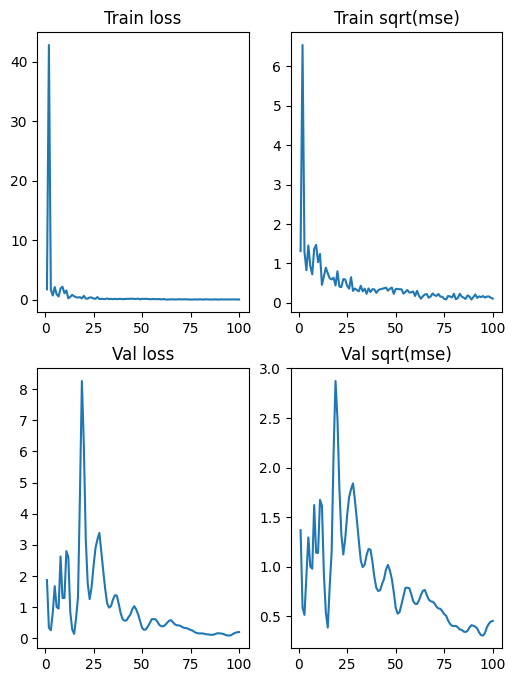

In [ ]:
# train('data/temperature_states', calc_sqrt_mse, calc_sqrt_mse, 'sqrt(mse)', 1, need_to_reshape=True)

In [132]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='DEFAULT')
model.fc = nn.Linear(in_features=512, out_features=3, bias=True)
model.load_state_dict(torch.load('/kaggle/working/states/best_model.pt'))

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/kaggle/working/states/model_scripted.pt') 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
<ipython-input-132-52d423e745e5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/states/best_model.pt'